# Model ResNet

https://www.pluralsight.com/guides/introduction-to-resnet

#### TODOS
1. DONE Debugging, does output make sense?
    1. Resize images
    2. preprocessing fixes
    5. replace scaling by proper function
2. try on leaderboard
3. Include Odometry and fuse into heads
    - Speed
    - Location
4. navigation
5. controller
6. Evaluation on Test set, Modularization



## Dependencies

In [1]:
# MODEL STUFF
import torch
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# GENERAL STUFF
import time
import copy
import os
import sys
#sys.path.insert(1, 'C:\\Users\\morit\\OneDrive\\UNI\\Master\\WS22\\APP-RAS\\Programming\\data_pipeline') # TODO

# DATA ENGINEERING
from data_pipeline.dataset_xy import CARLADatasetXY
from data_pipeline.dataset import CARLADataset
from data_pipeline.utils import train_test_split, create_metadata_df, measurements_to_df, render_example_video_from_folder_name

import pandas as pd
from tqdm import tqdm

## Model

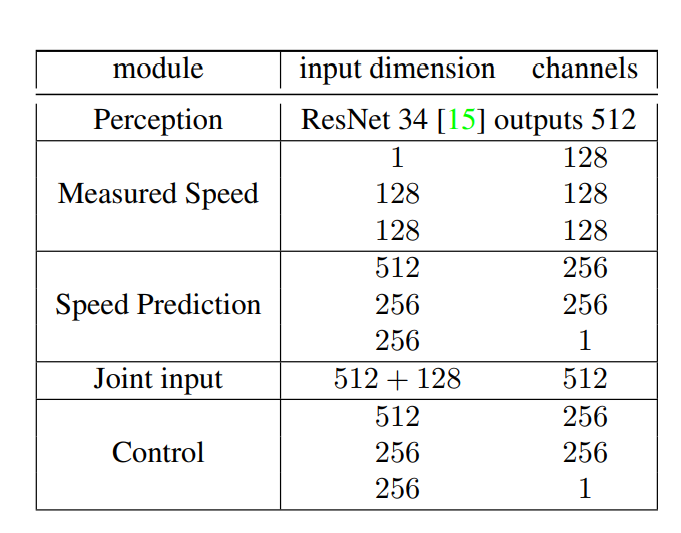

In [2]:
def mlp(neurons_in, neurons_out, neurons_hidden):
    return(nn.Sequential(
        nn.Linear(neurons_in, neurons_hidden),
        nn.Sigmoid(),
        nn.Linear(neurons_hidden, neurons_hidden),
        nn.Sigmoid(),
        nn.Linear(neurons_hidden, neurons_out),
        nn.Sigmoid()
    ))

def steer_head(neurons_in):# [-1,1] Range Output
    str_head = nn.Sequential(
        nn.Linear(neurons_in, 1),
        nn.Tanh())
    return str_head 
    
def throttle_head(neurons_in):# [0,1] Range Output
    thr_head = nn.Sequential(
        nn.Linear(neurons_in, 1),
        nn.Sigmoid())
    return thr_head
    
def brake_head(neurons_in):# [0,1] Range Output 
    brk_head = nn.Sequential(
        nn.Linear(neurons_in, 1),
        nn.Sigmoid())
    return brk_head
    

class MyResnet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # ResNet Architecture with pretrained weights, also bigger resnets available
        self.net = torchvision.models.resnet34(weights=True)
        num_ftrs = self.net.fc.in_features

        # Top layer of ResNet which you can modify. We choose Identity to use it as Input for all the heads
        self.net.fc = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False)
            #nn.Identity()
        )
        
        """
        # Input Layer fuer cmd, spd
        self.cmd_input = nn.Sequential(
            nn.Linear(7, 128),
            nn.Tanh() #nn.LeakyReLU() # TODO
            #nn.Dropout(p=0.5, inplace=False)
        )
        """
        
        self.spd_input = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(), 
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh()#nn.LeakyReLU() # TODO
            #nn.Dropout(p=0.5, inplace=False)
        )
        
        # shared MLP
        self.mlp = nn.Sequential(
            nn.Identity()
            
        )
        """
            nn.Linear(num_ftrs+128, num_ftrs+128),
            nn.Tanh(), #nn.LeakyReLU()
            nn.Dropout(p=0.1, inplace=False),
            nn.Linear(num_ftrs+128, num_ftrs+128),
            nn.Tanh(), #nn.LeakyReLU()
            nn.Dropout(p=0.1, inplace=False)
        """
        """
        self.W_list =  nn.ModuleList()

        for i  in range(relation_num):
        self.W_list.append(nn.Linear(self.dim, self.dim))
        """
        self.branches_mlp =  nn.ModuleList()
        self.branches_brake = nn.ModuleList()
        self.branches_steer = nn.ModuleList()
        self.branches_throttle = nn.ModuleList()
        
        for i in range(0,7):
            
            mlp_branch = mlp(num_ftrs+128, 256, 256)
            brk = brake_head(256)
            thr = throttle_head(256)
            steer = steer_head(256)
            
            self.branches_mlp.append(mlp_branch)
            self.branches_brake.append(brk)
            self.branches_steer.append(steer)
            self.branches_throttle.append(thr)
            
            
            

    # Forward Pass of the Model
    
    """
    def forward(cond, x):
    x=self.layer1(x)
    if cond:
        x=self.relu(x)
    ...
    return x
    """
    
    def forward(self, rgb, cmd, spd):
        rgb = self.net(rgb) # BRG
        #rgb = self.net.fc(rgb)
        #cmd = self.cmd_input(cmd)
        spd = self.spd_input(spd)
        
        x = torch.cat((rgb, spd),1)
        x = self.mlp(x)
        
        idx = torch.where(cmd[0])[0]
        #print(idx)
        x = self.branches_mlp[idx](x)
        
        brake = self.branches_brake[idx](x)
        steer = self.branches_steer[idx](x)
        throttle = self.branches_throttle[idx](x)
        
        
        return brake, steer, throttle


## Data Loaders, Data Sets

In [3]:
def adjust_df_meta_for_unique_command_batches(df_meta_data, batch_size):
    """
    Use this function if an model architecture is used where the prediction
    head depend on the specific command type.
    Returns the given df_meta_data in an adjusted version for the use of
    branch
    """
    # Add command as column to df_meta_data
    df_meta_data = df_meta_data.copy()
    print("Read all measurements from disk.")
    df_measurements = measurements_to_df(df_meta_data)
    print("All measurements in RAM! Now rebuild batches!")
    df_meta_data["command"] = df_measurements["command"]
    # Discard samples such that num_sample_per_command modulo batch_size = 0
    nums_to_discard = (df_meta_data.sort_values("command").value_counts("command") % batch_size).sort_index().values
    commands = np.sort(df_meta_data["command"].unique())
    for cmd_idx, cmd in enumerate(commands):
        idxs_discard = (df_meta_data
                        .query("command == @cmd")
                        .sample(nums_to_discard[cmd_idx])
                        .index)
        df_meta_data = df_meta_data.drop(index=idxs_discard)
    # Randomly sample batches of batch_size with same command until all samples are used
    batches_list = []
    num_batches = int(len(df_meta_data) / batch_size)
    # while not df_meta_data.empty:
    for _ in tqdm(range(num_batches)):
        # Next cmd to build batch with
        cmd = df_meta_data.sample()["command"].item()
        df_batch = df_meta_data.query("command == @cmd").sample(batch_size).copy()
        df_meta_data = df_meta_data.drop(index=df_batch.index).reset_index(drop=True)
        batches_list.append(df_batch)
    
    return pd.concat(batches_list, ignore_index=True).drop(columns=["command"])

In [4]:
batch_size = 64

#path_ege_data = os.path.join("..", "..", "data", "Dataset Ege")
train_path = "D:\\data\\Train"
test_path = "D:\\data\\Test"

config = {"used_inputs": ["rgb","measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "seq_len": 1
        }

"""
train_meta= create_metadata_df(train_path, config["used_inputs"])
test_meta = create_metadata_df(test_path, config["used_inputs"])

from tqdm import tqdm
import pandas as pd
train_meta= adjust_df_meta_for_unique_command_batches(train_meta, batch_size)
test_meta= adjust_df_meta_for_unique_command_batches(test_meta, batch_size)
"""


'\ntrain_meta= create_metadata_df(train_path, config["used_inputs"])\ntest_meta = create_metadata_df(test_path, config["used_inputs"])\n\nfrom tqdm import tqdm\nimport pandas as pd\ntrain_meta= adjust_df_meta_for_unique_command_batches(train_meta, batch_size)\ntest_meta= adjust_df_meta_for_unique_command_batches(test_meta, batch_size)\n'

Read all measurements from disk.


100%|█████████████████████████████████████████████████████████████████████████| 246281/246281 [26:07<00:00, 157.14it/s]


All measurements in RAM! Now rebuild batches!


100%|██████████████████████████████████████████████████████████████████████████████| 3844/3844 [02:34<00:00, 24.90it/s]


Read all measurements from disk.


100%|███████████████████████████████████████████████████████████████████████████| 24400/24400 [02:42<00:00, 150.44it/s]


All measurements in RAM! Now rebuild batches!


100%|███████████████████████████████████████████████████████████████████████████████| 379/379 [00:02<00:00, 132.13it/s]


In [ ]:
train_meta = pd.read_pickle(r'train_meta.pickle')
test_meta = pd.read_pickle(r'test_meta.pickle')

In [20]:
test_meta.head(5)

,dir,rgb,measurements
0,D:data\Test\coke_dataset_23_11\Routes_Scenario...,0010.png,0010.json
1,D:data\Test\coke_dataset_23_11\Routes_Scenario...,0157.png,0157.json
2,D:data\Test\coke_dataset_23_11\Routes_Scenario...,0025.png,0025.json
3,D:data\Test\coke_dataset_23_11\Routes_Scenario...,0016.png,0016.json
4,D:data\Test\coke_dataset_23_11\Routes_Scenario...,0090.png,0090.json


In [ ]:
"""
train_meta.to_pickle("train_meta.pickle")
test_meta.to_pickle("test_meta.pickle")
"""

In [7]:
train_dataset = CARLADataset(root_dir=train_path, df_meta_data=train_meta, config=config)
test_dataset = CARLADataset(root_dir=test_path, df_meta_data=test_meta, config=config)

#weighted_sampler = WeightedSampler(dataset=train_dataset)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
len(train_dataloader)

3844

In [9]:
len(test_dataloader)

379

In [10]:
augumentations = torch.nn.ModuleList([
        transforms.GaussianBlur(9),
        transforms.ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
        transforms.RandomErasing()
    ])

In [11]:
#mean = torch.tensor([79.6657, 81.5673, 105.6161]) BGR
#std = torch.tensor([66.8309, 60.1001, 66.2220])

mean = torch.tensor([105.6161, 81.5673, 79.6657]) # RGB
std = torch.tensor([66.2220, 60.1001, 66.8309])


transform_norm = transforms.Compose([
    transforms.Normalize(mean, std),
    transforms.Resize([224,224])
])

transform_augument = transforms.RandomApply(augumentations)

## Training

In [12]:
# Initialise Model (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = MyResnet().cuda() if device else net
net

C:\Users\morit\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyResnet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [13]:
def to_cuda_if_possible(data):
    return data.to(device) if device else data

In [14]:
def forward_pass(data, augument = True):
    # further preprocessing
    X_rgb = transform_norm(torch.squeeze(data["rgb"])).float()
    if False:#augument:
        X_rgb = transform_augument(X_rgb)
    labels = data["command"]
    #print(labels[0])
    #print(labels[3])
    #print(labels[6])
    labels = torch.where(labels == -1, torch.tensor(0), labels).to(torch.int64) # Replace by -1 by 0
    # Convert the labels to a one hot encoded tensor
    one_hot = torch.nn.functional.one_hot(labels, num_classes=7)
    X_cmd = torch.squeeze(one_hot).float()
    X_spd = ((data["speed"]-speed_mean)/speed_std).float()
    
    Y_throttle = data["throttle"].float()
    Y_steer = data["steer"].float()
    Y_brake = data["brake"].float()

    # move to GPU
    X_rgb = to_cuda_if_possible(X_rgb)
    X_cmd = to_cuda_if_possible(X_cmd)
    X_spd = to_cuda_if_possible(X_spd)
    
    Y_throttle = to_cuda_if_possible(Y_throttle)
    Y_steer = to_cuda_if_possible(Y_steer)
    Y_brake = to_cuda_if_possible(Y_brake)

    # compute outputs
    optimizer.zero_grad()

    Y_hat = net(X_rgb, X_cmd, X_spd)
    Y_hat_throttle = to_cuda_if_possible(Y_hat[2])
    Y_hat_steer = to_cuda_if_possible(Y_hat[1])
    Y_hat_brake = to_cuda_if_possible(Y_hat[0])

    # get labels from data
    Y_throttle = to_cuda_if_possible(data["throttle"].float())
    Y_steer = to_cuda_if_possible(data["steer"].float())
    Y_brake = to_cuda_if_possible(data["brake"].float())

    # Calculate Loss
    loss_throttle = 0.5*criterion(Y_hat_throttle, Y_throttle)
    loss_steer = 0.45*criterion(Y_hat_steer, Y_steer)
    loss_brake = 0.05*criterion(Y_hat_brake, Y_brake)
    loss = sum([loss_throttle, loss_steer, loss_brake])
    return loss

## Model Trainer Prototype

In [15]:
speed_mean = 2.382234##2.250456762830466
speed_std = 1.724884##0.30215840254891313

In [16]:
%%time

# Loss and Optimizer
criterion = nn.L1Loss() ##nn.MSELoss() ##  # Easy to interpret #
optimizer = optim.Adam(net.parameters(), lr=0.0001) #,weight_decay=1e-5 #optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

n_epochs = 4
print_every = 1
valid_loss_min = np.Inf
val_loss = []
train_loss = []
total_step = len(train_dataloader)

nan_batches = []

run = True

for epoch in range(1, n_epochs+1):
    
    running_loss = 0.0
    print(f'Epoch {epoch}\n')
    
    # Work through batches
    for batch_idx, data in enumerate(train_dataloader): #data: (['idx', 'rgb', 'speed', 'steer', 'throttle', 'brake'])

        loss = forward_pass(data)
        
        # Backprop
        loss.backward()
        optimizer.step()
        
        loss_value = loss.item()
        
        """
        if np.isnan(loss_value):
            print("nan", batch_idx)
            nan_batches.append((batch_idx, data))
         """   
        
        running_loss += loss_value
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss_value ))
        """
        et = time.time()
        print(et-at)
        at = time.time()
        """
        
    # Epoch finished, evaluate network and save if network_learned
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f},') # TODO SOLVE NAN ISSUES
    batch_loss = 0

    
    # Evaluation on Test set, skipped for now
  
    with torch.no_grad():
        net.eval()
        
        val_total_step = len(test_dataloader)
        
        for batch_idx, data in enumerate(test_dataloader):
            
            loss = forward_pass(data, False)
            
            loss_value = loss.item()
            
            if (batch_idx) % print_every == 0:
                print ('Validation [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch, n_epochs, batch_idx, val_total_step, loss_value ))
            
            batch_loss += loss_value
        val_loss.append(batch_loss/len(test_dataloader))
        mean_val_loss = np.mean(val_loss)
        
        print(f'validation loss: {mean_val_loss:.4f}, \n') # TODO SOLVE NAN ISSUES

        network_learned = mean_val_loss < valid_loss_min
        if True:#network_learned:
            valid_loss_min = mean_val_loss
            torch.save(net.state_dict(), 'resnet'+"_E-"+str(epoch)+"_noise_branched"+'.pth')
            #torch.save(net.state_dict(), "resnet_E-6.pth")
            print('Improvement-Detected, save-model')

    # Back to training
    net.train()

Epoch 1

Epoch [1/4], Step [0/3844], Loss: 0.3037
Epoch [1/4], Step [1/3844], Loss: 0.2881
Epoch [1/4], Step [2/3844], Loss: 0.2748
Epoch [1/4], Step [3/3844], Loss: 0.4646
Epoch [1/4], Step [4/3844], Loss: 0.2157
Epoch [1/4], Step [5/3844], Loss: 0.2647
Epoch [1/4], Step [6/3844], Loss: 0.3594
Epoch [1/4], Step [7/3844], Loss: 0.4003
Epoch [1/4], Step [8/3844], Loss: 0.2429
Epoch [1/4], Step [9/3844], Loss: 0.2481
Epoch [1/4], Step [10/3844], Loss: 0.2402
Epoch [1/4], Step [11/3844], Loss: 0.2576
Epoch [1/4], Step [12/3844], Loss: 0.2826
Epoch [1/4], Step [13/3844], Loss: 0.2473
Epoch [1/4], Step [14/3844], Loss: 0.2437
Epoch [1/4], Step [15/3844], Loss: 0.2746
Epoch [1/4], Step [16/3844], Loss: 0.2917
Epoch [1/4], Step [17/3844], Loss: 0.2307
Epoch [1/4], Step [18/3844], Loss: 0.2250
Epoch [1/4], Step [19/3844], Loss: 0.2184
Epoch [1/4], Step [20/3844], Loss: 0.2127
Epoch [1/4], Step [21/3844], Loss: 0.2103
Epoch [1/4], Step [22/3844], Loss: 0.3162
Epoch [1/4], Step [23/3844], Loss: 

Epoch [1/4], Step [193/3844], Loss: 0.2017
Epoch [1/4], Step [194/3844], Loss: 0.2046
Epoch [1/4], Step [195/3844], Loss: 0.1947
Epoch [1/4], Step [196/3844], Loss: 0.2202
Epoch [1/4], Step [197/3844], Loss: 0.2199
Epoch [1/4], Step [198/3844], Loss: 0.1962
Epoch [1/4], Step [199/3844], Loss: 0.2135
Epoch [1/4], Step [200/3844], Loss: 0.2173
Epoch [1/4], Step [201/3844], Loss: 0.2470
Epoch [1/4], Step [202/3844], Loss: 0.2102
Epoch [1/4], Step [203/3844], Loss: 0.2161
Epoch [1/4], Step [204/3844], Loss: 0.2078
Epoch [1/4], Step [205/3844], Loss: 0.2135
Epoch [1/4], Step [206/3844], Loss: 0.2086
Epoch [1/4], Step [207/3844], Loss: 0.1974
Epoch [1/4], Step [208/3844], Loss: 0.2058
Epoch [1/4], Step [209/3844], Loss: 0.2099
Epoch [1/4], Step [210/3844], Loss: 0.2039
Epoch [1/4], Step [211/3844], Loss: 0.2101
Epoch [1/4], Step [212/3844], Loss: 0.2158
Epoch [1/4], Step [213/3844], Loss: 0.1650
Epoch [1/4], Step [214/3844], Loss: 0.2194
Epoch [1/4], Step [215/3844], Loss: 0.2116
Epoch [1/4]

Epoch [1/4], Step [384/3844], Loss: 0.1764
Epoch [1/4], Step [385/3844], Loss: 0.2012
Epoch [1/4], Step [386/3844], Loss: 0.2232
Epoch [1/4], Step [387/3844], Loss: 0.1939
Epoch [1/4], Step [388/3844], Loss: 0.1995
Epoch [1/4], Step [389/3844], Loss: 0.2007
Epoch [1/4], Step [390/3844], Loss: 0.2161
Epoch [1/4], Step [391/3844], Loss: 0.2053
Epoch [1/4], Step [392/3844], Loss: 0.2046
Epoch [1/4], Step [393/3844], Loss: 0.1924
Epoch [1/4], Step [394/3844], Loss: 0.2152
Epoch [1/4], Step [395/3844], Loss: 0.1814
Epoch [1/4], Step [396/3844], Loss: 0.2101
Epoch [1/4], Step [397/3844], Loss: 0.2362
Epoch [1/4], Step [398/3844], Loss: 0.2135
Epoch [1/4], Step [399/3844], Loss: 0.1960
Epoch [1/4], Step [400/3844], Loss: 0.1793
Epoch [1/4], Step [401/3844], Loss: 0.2095
Epoch [1/4], Step [402/3844], Loss: 0.2080
Epoch [1/4], Step [403/3844], Loss: 0.1684
Epoch [1/4], Step [404/3844], Loss: 0.2069
Epoch [1/4], Step [405/3844], Loss: 0.1849
Epoch [1/4], Step [406/3844], Loss: 0.1888
Epoch [1/4]

Epoch [1/4], Step [575/3844], Loss: 0.2131
Epoch [1/4], Step [576/3844], Loss: 0.2042
Epoch [1/4], Step [577/3844], Loss: 0.1966
Epoch [1/4], Step [578/3844], Loss: 0.1906
Epoch [1/4], Step [579/3844], Loss: 0.2161
Epoch [1/4], Step [580/3844], Loss: 0.2361
Epoch [1/4], Step [581/3844], Loss: 0.2288
Epoch [1/4], Step [582/3844], Loss: 0.2085
Epoch [1/4], Step [583/3844], Loss: 0.1952
Epoch [1/4], Step [584/3844], Loss: 0.2160
Epoch [1/4], Step [585/3844], Loss: 0.2070
Epoch [1/4], Step [586/3844], Loss: 0.1922
Epoch [1/4], Step [587/3844], Loss: 0.1963
Epoch [1/4], Step [588/3844], Loss: 0.1818
Epoch [1/4], Step [589/3844], Loss: 0.2247
Epoch [1/4], Step [590/3844], Loss: 0.1996
Epoch [1/4], Step [591/3844], Loss: 0.2045
Epoch [1/4], Step [592/3844], Loss: 0.1687
Epoch [1/4], Step [593/3844], Loss: 0.1462
Epoch [1/4], Step [594/3844], Loss: 0.1729
Epoch [1/4], Step [595/3844], Loss: 0.2077
Epoch [1/4], Step [596/3844], Loss: 0.2225
Epoch [1/4], Step [597/3844], Loss: 0.2161
Epoch [1/4]

Epoch [1/4], Step [766/3844], Loss: 0.2028
Epoch [1/4], Step [767/3844], Loss: 0.2250
Epoch [1/4], Step [768/3844], Loss: 0.2201
Epoch [1/4], Step [769/3844], Loss: 0.1909
Epoch [1/4], Step [770/3844], Loss: 0.1858
Epoch [1/4], Step [771/3844], Loss: 0.2025
Epoch [1/4], Step [772/3844], Loss: 0.2159
Epoch [1/4], Step [773/3844], Loss: 0.1990
Epoch [1/4], Step [774/3844], Loss: 0.2220
Epoch [1/4], Step [775/3844], Loss: 0.2051
Epoch [1/4], Step [776/3844], Loss: 0.1959
Epoch [1/4], Step [777/3844], Loss: 0.1862
Epoch [1/4], Step [778/3844], Loss: 0.2038
Epoch [1/4], Step [779/3844], Loss: 0.2187
Epoch [1/4], Step [780/3844], Loss: 0.1910
Epoch [1/4], Step [781/3844], Loss: 0.2582
Epoch [1/4], Step [782/3844], Loss: 0.2402
Epoch [1/4], Step [783/3844], Loss: 0.1939
Epoch [1/4], Step [784/3844], Loss: 0.2011
Epoch [1/4], Step [785/3844], Loss: 0.1807
Epoch [1/4], Step [786/3844], Loss: 0.2019
Epoch [1/4], Step [787/3844], Loss: 0.1635
Epoch [1/4], Step [788/3844], Loss: 0.1915
Epoch [1/4]

Epoch [1/4], Step [957/3844], Loss: 0.1800
Epoch [1/4], Step [958/3844], Loss: 0.1886
Epoch [1/4], Step [959/3844], Loss: 0.2239
Epoch [1/4], Step [960/3844], Loss: 0.1910
Epoch [1/4], Step [961/3844], Loss: 0.2033
Epoch [1/4], Step [962/3844], Loss: 0.2051
Epoch [1/4], Step [963/3844], Loss: 0.1695
Epoch [1/4], Step [964/3844], Loss: 0.1803
Epoch [1/4], Step [965/3844], Loss: 0.1558
Epoch [1/4], Step [966/3844], Loss: 0.1991
Epoch [1/4], Step [967/3844], Loss: 0.1926
Epoch [1/4], Step [968/3844], Loss: 0.2062
Epoch [1/4], Step [969/3844], Loss: 0.2038
Epoch [1/4], Step [970/3844], Loss: 0.1935
Epoch [1/4], Step [971/3844], Loss: 0.1929
Epoch [1/4], Step [972/3844], Loss: 0.2047
Epoch [1/4], Step [973/3844], Loss: 0.1983
Epoch [1/4], Step [974/3844], Loss: 0.2333
Epoch [1/4], Step [975/3844], Loss: 0.1971
Epoch [1/4], Step [976/3844], Loss: 0.2361
Epoch [1/4], Step [977/3844], Loss: 0.1991
Epoch [1/4], Step [978/3844], Loss: 0.2037
Epoch [1/4], Step [979/3844], Loss: 0.1960
Epoch [1/4]

Epoch [1/4], Step [1145/3844], Loss: 0.1890
Epoch [1/4], Step [1146/3844], Loss: 0.1838
Epoch [1/4], Step [1147/3844], Loss: 0.2078
Epoch [1/4], Step [1148/3844], Loss: 0.1842
Epoch [1/4], Step [1149/3844], Loss: 0.1970
Epoch [1/4], Step [1150/3844], Loss: 0.2124
Epoch [1/4], Step [1151/3844], Loss: 0.1812
Epoch [1/4], Step [1152/3844], Loss: 0.1922
Epoch [1/4], Step [1153/3844], Loss: 0.2503
Epoch [1/4], Step [1154/3844], Loss: 0.1972
Epoch [1/4], Step [1155/3844], Loss: 0.2193
Epoch [1/4], Step [1156/3844], Loss: 0.1910
Epoch [1/4], Step [1157/3844], Loss: 0.2428
Epoch [1/4], Step [1158/3844], Loss: 0.1729
Epoch [1/4], Step [1159/3844], Loss: 0.1832
Epoch [1/4], Step [1160/3844], Loss: 0.3010
Epoch [1/4], Step [1161/3844], Loss: 0.1925
Epoch [1/4], Step [1162/3844], Loss: 0.2114
Epoch [1/4], Step [1163/3844], Loss: 0.2011
Epoch [1/4], Step [1164/3844], Loss: 0.1530
Epoch [1/4], Step [1165/3844], Loss: 0.1974
Epoch [1/4], Step [1166/3844], Loss: 0.1978
Epoch [1/4], Step [1167/3844], L

Epoch [1/4], Step [1332/3844], Loss: 0.1914
Epoch [1/4], Step [1333/3844], Loss: 0.1916
Epoch [1/4], Step [1334/3844], Loss: 0.1837
Epoch [1/4], Step [1335/3844], Loss: 0.1644
Epoch [1/4], Step [1336/3844], Loss: 0.1776
Epoch [1/4], Step [1337/3844], Loss: 0.1827
Epoch [1/4], Step [1338/3844], Loss: 0.1797
Epoch [1/4], Step [1339/3844], Loss: 0.1687
Epoch [1/4], Step [1340/3844], Loss: 0.1952
Epoch [1/4], Step [1341/3844], Loss: 0.1670
Epoch [1/4], Step [1342/3844], Loss: 0.1786
Epoch [1/4], Step [1343/3844], Loss: 0.2434
Epoch [1/4], Step [1344/3844], Loss: 0.1643
Epoch [1/4], Step [1345/3844], Loss: 0.2085
Epoch [1/4], Step [1346/3844], Loss: 0.1642
Epoch [1/4], Step [1347/3844], Loss: 0.1521
Epoch [1/4], Step [1348/3844], Loss: 0.1902
Epoch [1/4], Step [1349/3844], Loss: 0.2063
Epoch [1/4], Step [1350/3844], Loss: 0.1728
Epoch [1/4], Step [1351/3844], Loss: 0.1800
Epoch [1/4], Step [1352/3844], Loss: 0.1460
Epoch [1/4], Step [1353/3844], Loss: 0.2070
Epoch [1/4], Step [1354/3844], L

Epoch [1/4], Step [1519/3844], Loss: 0.2130
Epoch [1/4], Step [1520/3844], Loss: 0.1857
Epoch [1/4], Step [1521/3844], Loss: 0.1917
Epoch [1/4], Step [1522/3844], Loss: 0.1557
Epoch [1/4], Step [1523/3844], Loss: 0.1501
Epoch [1/4], Step [1524/3844], Loss: 0.1752
Epoch [1/4], Step [1525/3844], Loss: 0.1886
Epoch [1/4], Step [1526/3844], Loss: 0.2469
Epoch [1/4], Step [1527/3844], Loss: 0.1861
Epoch [1/4], Step [1528/3844], Loss: 0.1768
Epoch [1/4], Step [1529/3844], Loss: 0.1683
Epoch [1/4], Step [1530/3844], Loss: 0.1817
Epoch [1/4], Step [1531/3844], Loss: 0.1678
Epoch [1/4], Step [1532/3844], Loss: 0.1751
Epoch [1/4], Step [1533/3844], Loss: 0.1755
Epoch [1/4], Step [1534/3844], Loss: 0.1735
Epoch [1/4], Step [1535/3844], Loss: 0.1889
Epoch [1/4], Step [1536/3844], Loss: 0.1708
Epoch [1/4], Step [1537/3844], Loss: 0.1740
Epoch [1/4], Step [1538/3844], Loss: 0.2597
Epoch [1/4], Step [1539/3844], Loss: 0.2321
Epoch [1/4], Step [1540/3844], Loss: 0.1806
Epoch [1/4], Step [1541/3844], L

Epoch [1/4], Step [1706/3844], Loss: 0.1848
Epoch [1/4], Step [1707/3844], Loss: 0.1810
Epoch [1/4], Step [1708/3844], Loss: 0.1730
Epoch [1/4], Step [1709/3844], Loss: 0.1736
Epoch [1/4], Step [1710/3844], Loss: 0.1785
Epoch [1/4], Step [1711/3844], Loss: 0.2268
Epoch [1/4], Step [1712/3844], Loss: 0.1876
Epoch [1/4], Step [1713/3844], Loss: 0.1830
Epoch [1/4], Step [1714/3844], Loss: 0.1755
Epoch [1/4], Step [1715/3844], Loss: 0.1646
Epoch [1/4], Step [1716/3844], Loss: 0.1856
Epoch [1/4], Step [1717/3844], Loss: 0.1568
Epoch [1/4], Step [1718/3844], Loss: 0.1581
Epoch [1/4], Step [1719/3844], Loss: 0.2112
Epoch [1/4], Step [1720/3844], Loss: 0.1836
Epoch [1/4], Step [1721/3844], Loss: 0.2005
Epoch [1/4], Step [1722/3844], Loss: 0.2025
Epoch [1/4], Step [1723/3844], Loss: 0.1751
Epoch [1/4], Step [1724/3844], Loss: 0.1689
Epoch [1/4], Step [1725/3844], Loss: 0.1635
Epoch [1/4], Step [1726/3844], Loss: 0.2130
Epoch [1/4], Step [1727/3844], Loss: 0.1842
Epoch [1/4], Step [1728/3844], L

Epoch [1/4], Step [1893/3844], Loss: 0.1756
Epoch [1/4], Step [1894/3844], Loss: 0.1263
Epoch [1/4], Step [1895/3844], Loss: 0.1860
Epoch [1/4], Step [1896/3844], Loss: 0.1703
Epoch [1/4], Step [1897/3844], Loss: 0.1674
Epoch [1/4], Step [1898/3844], Loss: 0.1901
Epoch [1/4], Step [1899/3844], Loss: 0.1720
Epoch [1/4], Step [1900/3844], Loss: 0.2318
Epoch [1/4], Step [1901/3844], Loss: 0.1824
Epoch [1/4], Step [1902/3844], Loss: 0.1990
Epoch [1/4], Step [1903/3844], Loss: 0.1628
Epoch [1/4], Step [1904/3844], Loss: 0.2013
Epoch [1/4], Step [1905/3844], Loss: 0.2288
Epoch [1/4], Step [1906/3844], Loss: 0.1649
Epoch [1/4], Step [1907/3844], Loss: 0.1815
Epoch [1/4], Step [1908/3844], Loss: 0.1931
Epoch [1/4], Step [1909/3844], Loss: 0.1936
Epoch [1/4], Step [1910/3844], Loss: 0.2145
Epoch [1/4], Step [1911/3844], Loss: 0.1736
Epoch [1/4], Step [1912/3844], Loss: 0.1701
Epoch [1/4], Step [1913/3844], Loss: 0.1977
Epoch [1/4], Step [1914/3844], Loss: 0.1954
Epoch [1/4], Step [1915/3844], L

Epoch [1/4], Step [2080/3844], Loss: 0.1758
Epoch [1/4], Step [2081/3844], Loss: 0.1885
Epoch [1/4], Step [2082/3844], Loss: 0.1772
Epoch [1/4], Step [2083/3844], Loss: 0.1891
Epoch [1/4], Step [2084/3844], Loss: 0.1853
Epoch [1/4], Step [2085/3844], Loss: 0.1781
Epoch [1/4], Step [2086/3844], Loss: 0.1790
Epoch [1/4], Step [2087/3844], Loss: 0.1792
Epoch [1/4], Step [2088/3844], Loss: 0.1556
Epoch [1/4], Step [2089/3844], Loss: 0.1657
Epoch [1/4], Step [2090/3844], Loss: 0.1897
Epoch [1/4], Step [2091/3844], Loss: 0.1803
Epoch [1/4], Step [2092/3844], Loss: 0.1804
Epoch [1/4], Step [2093/3844], Loss: 0.1779
Epoch [1/4], Step [2094/3844], Loss: 0.1342
Epoch [1/4], Step [2095/3844], Loss: 0.1437
Epoch [1/4], Step [2096/3844], Loss: 0.1525
Epoch [1/4], Step [2097/3844], Loss: 0.1842
Epoch [1/4], Step [2098/3844], Loss: 0.1951
Epoch [1/4], Step [2099/3844], Loss: 0.2095
Epoch [1/4], Step [2100/3844], Loss: 0.1701
Epoch [1/4], Step [2101/3844], Loss: 0.2282
Epoch [1/4], Step [2102/3844], L

Epoch [1/4], Step [2267/3844], Loss: 0.1866
Epoch [1/4], Step [2268/3844], Loss: 0.1644
Epoch [1/4], Step [2269/3844], Loss: 0.1667
Epoch [1/4], Step [2270/3844], Loss: 0.1825
Epoch [1/4], Step [2271/3844], Loss: 0.1757
Epoch [1/4], Step [2272/3844], Loss: 0.1767
Epoch [1/4], Step [2273/3844], Loss: 0.1809
Epoch [1/4], Step [2274/3844], Loss: 0.2077
Epoch [1/4], Step [2275/3844], Loss: 0.1954
Epoch [1/4], Step [2276/3844], Loss: 0.1629
Epoch [1/4], Step [2277/3844], Loss: 0.1605
Epoch [1/4], Step [2278/3844], Loss: 0.1644
Epoch [1/4], Step [2279/3844], Loss: 0.2036
Epoch [1/4], Step [2280/3844], Loss: 0.1902
Epoch [1/4], Step [2281/3844], Loss: 0.1453
Epoch [1/4], Step [2282/3844], Loss: 0.1523
Epoch [1/4], Step [2283/3844], Loss: 0.1784
Epoch [1/4], Step [2284/3844], Loss: 0.1617
Epoch [1/4], Step [2285/3844], Loss: 0.1796
Epoch [1/4], Step [2286/3844], Loss: 0.1979
Epoch [1/4], Step [2287/3844], Loss: 0.1885
Epoch [1/4], Step [2288/3844], Loss: 0.1862
Epoch [1/4], Step [2289/3844], L

Epoch [1/4], Step [2454/3844], Loss: 0.1741
Epoch [1/4], Step [2455/3844], Loss: 0.1527
Epoch [1/4], Step [2456/3844], Loss: 0.1819
Epoch [1/4], Step [2457/3844], Loss: 0.1571
Epoch [1/4], Step [2458/3844], Loss: 0.1299
Epoch [1/4], Step [2459/3844], Loss: 0.1905
Epoch [1/4], Step [2460/3844], Loss: 0.1862
Epoch [1/4], Step [2461/3844], Loss: 0.2412
Epoch [1/4], Step [2462/3844], Loss: 0.1491
Epoch [1/4], Step [2463/3844], Loss: 0.1539
Epoch [1/4], Step [2464/3844], Loss: 0.3128
Epoch [1/4], Step [2465/3844], Loss: 0.1388
Epoch [1/4], Step [2466/3844], Loss: 0.2976
Epoch [1/4], Step [2467/3844], Loss: 0.2272
Epoch [1/4], Step [2468/3844], Loss: 0.1849
Epoch [1/4], Step [2469/3844], Loss: 0.1604
Epoch [1/4], Step [2470/3844], Loss: 0.1855
Epoch [1/4], Step [2471/3844], Loss: 0.1991
Epoch [1/4], Step [2472/3844], Loss: 0.1547
Epoch [1/4], Step [2473/3844], Loss: 0.1423
Epoch [1/4], Step [2474/3844], Loss: 0.1710
Epoch [1/4], Step [2475/3844], Loss: 0.1989
Epoch [1/4], Step [2476/3844], L

Epoch [1/4], Step [2641/3844], Loss: 0.2942
Epoch [1/4], Step [2642/3844], Loss: 0.1974
Epoch [1/4], Step [2643/3844], Loss: 0.1866
Epoch [1/4], Step [2644/3844], Loss: 0.1771
Epoch [1/4], Step [2645/3844], Loss: 0.1878
Epoch [1/4], Step [2646/3844], Loss: 0.1848
Epoch [1/4], Step [2647/3844], Loss: 0.1771
Epoch [1/4], Step [2648/3844], Loss: 0.1407
Epoch [1/4], Step [2649/3844], Loss: 0.1467
Epoch [1/4], Step [2650/3844], Loss: 0.2114
Epoch [1/4], Step [2651/3844], Loss: 0.1900
Epoch [1/4], Step [2652/3844], Loss: 0.1912
Epoch [1/4], Step [2653/3844], Loss: 0.1589
Epoch [1/4], Step [2654/3844], Loss: 0.1444
Epoch [1/4], Step [2655/3844], Loss: 0.1904
Epoch [1/4], Step [2656/3844], Loss: 0.2377
Epoch [1/4], Step [2657/3844], Loss: 0.2338
Epoch [1/4], Step [2658/3844], Loss: 0.1569
Epoch [1/4], Step [2659/3844], Loss: 0.1682
Epoch [1/4], Step [2660/3844], Loss: 0.1863
Epoch [1/4], Step [2661/3844], Loss: 0.1590
Epoch [1/4], Step [2662/3844], Loss: 0.1639
Epoch [1/4], Step [2663/3844], L

Epoch [1/4], Step [2828/3844], Loss: 0.1796
Epoch [1/4], Step [2829/3844], Loss: 0.1486
Epoch [1/4], Step [2830/3844], Loss: 0.1936
Epoch [1/4], Step [2831/3844], Loss: 0.1739
Epoch [1/4], Step [2832/3844], Loss: 0.1588
Epoch [1/4], Step [2833/3844], Loss: 0.1854
Epoch [1/4], Step [2834/3844], Loss: 0.1706
Epoch [1/4], Step [2835/3844], Loss: 0.1624
Epoch [1/4], Step [2836/3844], Loss: 0.1941
Epoch [1/4], Step [2837/3844], Loss: 0.1639
Epoch [1/4], Step [2838/3844], Loss: 0.1618
Epoch [1/4], Step [2839/3844], Loss: 0.1537
Epoch [1/4], Step [2840/3844], Loss: 0.1623
Epoch [1/4], Step [2841/3844], Loss: 0.2094
Epoch [1/4], Step [2842/3844], Loss: 0.1721
Epoch [1/4], Step [2843/3844], Loss: 0.1424
Epoch [1/4], Step [2844/3844], Loss: 0.1972
Epoch [1/4], Step [2845/3844], Loss: 0.2088
Epoch [1/4], Step [2846/3844], Loss: 0.1941
Epoch [1/4], Step [2847/3844], Loss: 0.1952
Epoch [1/4], Step [2848/3844], Loss: 0.2027
Epoch [1/4], Step [2849/3844], Loss: 0.2224
Epoch [1/4], Step [2850/3844], L

Epoch [1/4], Step [3015/3844], Loss: 0.1565
Epoch [1/4], Step [3016/3844], Loss: 0.1444
Epoch [1/4], Step [3017/3844], Loss: 0.1638
Epoch [1/4], Step [3018/3844], Loss: 0.1568
Epoch [1/4], Step [3019/3844], Loss: 0.1528
Epoch [1/4], Step [3020/3844], Loss: 0.1815
Epoch [1/4], Step [3021/3844], Loss: 0.2231
Epoch [1/4], Step [3022/3844], Loss: 0.1833
Epoch [1/4], Step [3023/3844], Loss: 0.1782
Epoch [1/4], Step [3024/3844], Loss: 0.1594
Epoch [1/4], Step [3025/3844], Loss: 0.1773
Epoch [1/4], Step [3026/3844], Loss: 0.1486
Epoch [1/4], Step [3027/3844], Loss: 0.2059
Epoch [1/4], Step [3028/3844], Loss: 0.1476
Epoch [1/4], Step [3029/3844], Loss: 0.1718
Epoch [1/4], Step [3030/3844], Loss: 0.1791
Epoch [1/4], Step [3031/3844], Loss: 0.1485
Epoch [1/4], Step [3032/3844], Loss: 0.1565
Epoch [1/4], Step [3033/3844], Loss: 0.1722
Epoch [1/4], Step [3034/3844], Loss: 0.1279
Epoch [1/4], Step [3035/3844], Loss: 0.2279
Epoch [1/4], Step [3036/3844], Loss: 0.1267
Epoch [1/4], Step [3037/3844], L

Epoch [1/4], Step [3202/3844], Loss: 0.1543
Epoch [1/4], Step [3203/3844], Loss: 0.1894
Epoch [1/4], Step [3204/3844], Loss: 0.1675
Epoch [1/4], Step [3205/3844], Loss: 0.1990
Epoch [1/4], Step [3206/3844], Loss: 0.2277
Epoch [1/4], Step [3207/3844], Loss: 0.1744
Epoch [1/4], Step [3208/3844], Loss: 0.1522
Epoch [1/4], Step [3209/3844], Loss: 0.1461
Epoch [1/4], Step [3210/3844], Loss: 0.2238
Epoch [1/4], Step [3211/3844], Loss: 0.1661
Epoch [1/4], Step [3212/3844], Loss: 0.1657
Epoch [1/4], Step [3213/3844], Loss: 0.1610
Epoch [1/4], Step [3214/3844], Loss: 0.1635
Epoch [1/4], Step [3215/3844], Loss: 0.2106
Epoch [1/4], Step [3216/3844], Loss: 0.1583
Epoch [1/4], Step [3217/3844], Loss: 0.1936
Epoch [1/4], Step [3218/3844], Loss: 0.1953
Epoch [1/4], Step [3219/3844], Loss: 0.1615
Epoch [1/4], Step [3220/3844], Loss: 0.1751
Epoch [1/4], Step [3221/3844], Loss: 0.1824
Epoch [1/4], Step [3222/3844], Loss: 0.1533
Epoch [1/4], Step [3223/3844], Loss: 0.2312
Epoch [1/4], Step [3224/3844], L

Epoch [1/4], Step [3389/3844], Loss: 0.1362
Epoch [1/4], Step [3390/3844], Loss: 0.1983
Epoch [1/4], Step [3391/3844], Loss: 0.1406
Epoch [1/4], Step [3392/3844], Loss: 0.2811
Epoch [1/4], Step [3393/3844], Loss: 0.1742
Epoch [1/4], Step [3394/3844], Loss: 0.1886
Epoch [1/4], Step [3395/3844], Loss: 0.1410
Epoch [1/4], Step [3396/3844], Loss: 0.2179
Epoch [1/4], Step [3397/3844], Loss: 0.1764
Epoch [1/4], Step [3398/3844], Loss: 0.1379
Epoch [1/4], Step [3399/3844], Loss: 0.1953
Epoch [1/4], Step [3400/3844], Loss: 0.1377
Epoch [1/4], Step [3401/3844], Loss: 0.1574
Epoch [1/4], Step [3402/3844], Loss: 0.1514
Epoch [1/4], Step [3403/3844], Loss: 0.1655
Epoch [1/4], Step [3404/3844], Loss: 0.1780
Epoch [1/4], Step [3405/3844], Loss: 0.1591
Epoch [1/4], Step [3406/3844], Loss: 0.1672
Epoch [1/4], Step [3407/3844], Loss: 0.1922
Epoch [1/4], Step [3408/3844], Loss: 0.1591
Epoch [1/4], Step [3409/3844], Loss: 0.1623
Epoch [1/4], Step [3410/3844], Loss: 0.1981
Epoch [1/4], Step [3411/3844], L

Epoch [1/4], Step [3576/3844], Loss: 0.1930
Epoch [1/4], Step [3577/3844], Loss: 0.1368
Epoch [1/4], Step [3578/3844], Loss: 0.1711
Epoch [1/4], Step [3579/3844], Loss: 0.1502
Epoch [1/4], Step [3580/3844], Loss: 0.1119
Epoch [1/4], Step [3581/3844], Loss: 0.1495
Epoch [1/4], Step [3582/3844], Loss: 0.1908
Epoch [1/4], Step [3583/3844], Loss: 0.1650
Epoch [1/4], Step [3584/3844], Loss: 0.1454
Epoch [1/4], Step [3585/3844], Loss: 0.1529
Epoch [1/4], Step [3586/3844], Loss: 0.1573
Epoch [1/4], Step [3587/3844], Loss: 0.1563
Epoch [1/4], Step [3588/3844], Loss: 0.1670
Epoch [1/4], Step [3589/3844], Loss: 0.1439
Epoch [1/4], Step [3590/3844], Loss: 0.1771
Epoch [1/4], Step [3591/3844], Loss: 0.1682
Epoch [1/4], Step [3592/3844], Loss: 0.1712
Epoch [1/4], Step [3593/3844], Loss: 0.1988
Epoch [1/4], Step [3594/3844], Loss: 0.1546
Epoch [1/4], Step [3595/3844], Loss: 0.1626
Epoch [1/4], Step [3596/3844], Loss: 0.2281
Epoch [1/4], Step [3597/3844], Loss: 0.1848
Epoch [1/4], Step [3598/3844], L

Epoch [1/4], Step [3763/3844], Loss: 0.1807
Epoch [1/4], Step [3764/3844], Loss: 0.2270
Epoch [1/4], Step [3765/3844], Loss: 0.1636
Epoch [1/4], Step [3766/3844], Loss: 0.1622
Epoch [1/4], Step [3767/3844], Loss: 0.1483
Epoch [1/4], Step [3768/3844], Loss: 0.2176
Epoch [1/4], Step [3769/3844], Loss: 0.1541
Epoch [1/4], Step [3770/3844], Loss: 0.1623
Epoch [1/4], Step [3771/3844], Loss: 0.1649
Epoch [1/4], Step [3772/3844], Loss: 0.2157
Epoch [1/4], Step [3773/3844], Loss: 0.1729
Epoch [1/4], Step [3774/3844], Loss: 0.1670
Epoch [1/4], Step [3775/3844], Loss: 0.1675
Epoch [1/4], Step [3776/3844], Loss: 0.1613
Epoch [1/4], Step [3777/3844], Loss: 0.1402
Epoch [1/4], Step [3778/3844], Loss: 0.1522
Epoch [1/4], Step [3779/3844], Loss: 0.1589
Epoch [1/4], Step [3780/3844], Loss: 0.1768
Epoch [1/4], Step [3781/3844], Loss: 0.1544
Epoch [1/4], Step [3782/3844], Loss: 0.1433
Epoch [1/4], Step [3783/3844], Loss: 0.1557
Epoch [1/4], Step [3784/3844], Loss: 0.1589
Epoch [1/4], Step [3785/3844], L

Validation [1/4], Step [101/379], Loss: 0.1126
Validation [1/4], Step [102/379], Loss: 0.1297
Validation [1/4], Step [103/379], Loss: 0.1106
Validation [1/4], Step [104/379], Loss: 0.1028
Validation [1/4], Step [105/379], Loss: 0.1008
Validation [1/4], Step [106/379], Loss: 0.1011
Validation [1/4], Step [107/379], Loss: 0.1116
Validation [1/4], Step [108/379], Loss: 0.1010
Validation [1/4], Step [109/379], Loss: 0.0877
Validation [1/4], Step [110/379], Loss: 0.1209
Validation [1/4], Step [111/379], Loss: 0.1297
Validation [1/4], Step [112/379], Loss: 0.1004
Validation [1/4], Step [113/379], Loss: 0.1166
Validation [1/4], Step [114/379], Loss: 0.1226
Validation [1/4], Step [115/379], Loss: 0.1025
Validation [1/4], Step [116/379], Loss: 0.1023
Validation [1/4], Step [117/379], Loss: 0.1139
Validation [1/4], Step [118/379], Loss: 0.0941
Validation [1/4], Step [119/379], Loss: 0.0939
Validation [1/4], Step [120/379], Loss: 0.1052
Validation [1/4], Step [121/379], Loss: 0.1202
Validation [1

Validation [1/4], Step [276/379], Loss: 0.1093
Validation [1/4], Step [277/379], Loss: 0.1023
Validation [1/4], Step [278/379], Loss: 0.1089
Validation [1/4], Step [279/379], Loss: 0.0951
Validation [1/4], Step [280/379], Loss: 0.0970
Validation [1/4], Step [281/379], Loss: 0.1150
Validation [1/4], Step [282/379], Loss: 0.1030
Validation [1/4], Step [283/379], Loss: 0.1019
Validation [1/4], Step [284/379], Loss: 0.1003
Validation [1/4], Step [285/379], Loss: 0.1119
Validation [1/4], Step [286/379], Loss: 0.1065
Validation [1/4], Step [287/379], Loss: 0.1168
Validation [1/4], Step [288/379], Loss: 0.1079
Validation [1/4], Step [289/379], Loss: 0.1154
Validation [1/4], Step [290/379], Loss: 0.1080
Validation [1/4], Step [291/379], Loss: 0.1206
Validation [1/4], Step [292/379], Loss: 0.1015
Validation [1/4], Step [293/379], Loss: 0.1038
Validation [1/4], Step [294/379], Loss: 0.1156
Validation [1/4], Step [295/379], Loss: 0.1060
Validation [1/4], Step [296/379], Loss: 0.1139
Validation [1

Epoch [2/4], Step [79/3844], Loss: 0.1697
Epoch [2/4], Step [80/3844], Loss: 0.1241
Epoch [2/4], Step [81/3844], Loss: 0.1685
Epoch [2/4], Step [82/3844], Loss: 0.1238
Epoch [2/4], Step [83/3844], Loss: 0.1809
Epoch [2/4], Step [84/3844], Loss: 0.1218
Epoch [2/4], Step [85/3844], Loss: 0.2324
Epoch [2/4], Step [86/3844], Loss: 0.1259
Epoch [2/4], Step [87/3844], Loss: 0.2347
Epoch [2/4], Step [88/3844], Loss: 0.1195
Epoch [2/4], Step [89/3844], Loss: 0.1538
Epoch [2/4], Step [90/3844], Loss: 0.1484
Epoch [2/4], Step [91/3844], Loss: 0.1564
Epoch [2/4], Step [92/3844], Loss: 0.1112
Epoch [2/4], Step [93/3844], Loss: 0.1267
Epoch [2/4], Step [94/3844], Loss: 0.2318
Epoch [2/4], Step [95/3844], Loss: 0.1451
Epoch [2/4], Step [96/3844], Loss: 0.1223
Epoch [2/4], Step [97/3844], Loss: 0.1220
Epoch [2/4], Step [98/3844], Loss: 0.1284
Epoch [2/4], Step [99/3844], Loss: 0.2220
Epoch [2/4], Step [100/3844], Loss: 0.1262
Epoch [2/4], Step [101/3844], Loss: 0.1154
Epoch [2/4], Step [102/3844], Lo

Epoch [2/4], Step [271/3844], Loss: 0.1695
Epoch [2/4], Step [272/3844], Loss: 0.1052
Epoch [2/4], Step [273/3844], Loss: 0.0926
Epoch [2/4], Step [274/3844], Loss: 0.2151
Epoch [2/4], Step [275/3844], Loss: 0.1250
Epoch [2/4], Step [276/3844], Loss: 0.1622
Epoch [2/4], Step [277/3844], Loss: 0.0920
Epoch [2/4], Step [278/3844], Loss: 0.1141
Epoch [2/4], Step [279/3844], Loss: 0.1410
Epoch [2/4], Step [280/3844], Loss: 0.1329
Epoch [2/4], Step [281/3844], Loss: 0.2314
Epoch [2/4], Step [282/3844], Loss: 0.0938
Epoch [2/4], Step [283/3844], Loss: 0.1717
Epoch [2/4], Step [284/3844], Loss: 0.1224
Epoch [2/4], Step [285/3844], Loss: 0.0774
Epoch [2/4], Step [286/3844], Loss: 0.0791
Epoch [2/4], Step [287/3844], Loss: 0.1043
Epoch [2/4], Step [288/3844], Loss: 0.1847
Epoch [2/4], Step [289/3844], Loss: 0.0970
Epoch [2/4], Step [290/3844], Loss: 0.1615
Epoch [2/4], Step [291/3844], Loss: 0.1637
Epoch [2/4], Step [292/3844], Loss: 0.1110
Epoch [2/4], Step [293/3844], Loss: 0.0870
Epoch [2/4]

Epoch [2/4], Step [462/3844], Loss: 0.2160
Epoch [2/4], Step [463/3844], Loss: 0.1047
Epoch [2/4], Step [464/3844], Loss: 0.0991
Epoch [2/4], Step [465/3844], Loss: 0.2546
Epoch [2/4], Step [466/3844], Loss: 0.0979
Epoch [2/4], Step [467/3844], Loss: 0.2451
Epoch [2/4], Step [468/3844], Loss: 0.1522
Epoch [2/4], Step [469/3844], Loss: 0.0940
Epoch [2/4], Step [470/3844], Loss: 0.0708
Epoch [2/4], Step [471/3844], Loss: 0.1402
Epoch [2/4], Step [472/3844], Loss: 0.1179
Epoch [2/4], Step [473/3844], Loss: 0.0834
Epoch [2/4], Step [474/3844], Loss: 0.1028
Epoch [2/4], Step [475/3844], Loss: 0.1537
Epoch [2/4], Step [476/3844], Loss: 0.0752
Epoch [2/4], Step [477/3844], Loss: 0.2204
Epoch [2/4], Step [478/3844], Loss: 0.1124
Epoch [2/4], Step [479/3844], Loss: 0.1451
Epoch [2/4], Step [480/3844], Loss: 0.1832
Epoch [2/4], Step [481/3844], Loss: 0.0772
Epoch [2/4], Step [482/3844], Loss: 0.0998
Epoch [2/4], Step [483/3844], Loss: 0.1424
Epoch [2/4], Step [484/3844], Loss: 0.0879
Epoch [2/4]

Epoch [2/4], Step [653/3844], Loss: 0.1000
Epoch [2/4], Step [654/3844], Loss: 0.0880
Epoch [2/4], Step [655/3844], Loss: 0.0968
Epoch [2/4], Step [656/3844], Loss: 0.1039
Epoch [2/4], Step [657/3844], Loss: 0.1053
Epoch [2/4], Step [658/3844], Loss: 0.0839
Epoch [2/4], Step [659/3844], Loss: 0.1558
Epoch [2/4], Step [660/3844], Loss: 0.1213
Epoch [2/4], Step [661/3844], Loss: 0.0948
Epoch [2/4], Step [662/3844], Loss: 0.1353
Epoch [2/4], Step [663/3844], Loss: 0.0853
Epoch [2/4], Step [664/3844], Loss: 0.1594
Epoch [2/4], Step [665/3844], Loss: 0.0911
Epoch [2/4], Step [666/3844], Loss: 0.1474
Epoch [2/4], Step [667/3844], Loss: 0.0977
Epoch [2/4], Step [668/3844], Loss: 0.0715
Epoch [2/4], Step [669/3844], Loss: 0.0978
Epoch [2/4], Step [670/3844], Loss: 0.1438
Epoch [2/4], Step [671/3844], Loss: 0.1687
Epoch [2/4], Step [672/3844], Loss: 0.1770
Epoch [2/4], Step [673/3844], Loss: 0.1264
Epoch [2/4], Step [674/3844], Loss: 0.0812
Epoch [2/4], Step [675/3844], Loss: 0.1377
Epoch [2/4]

Epoch [2/4], Step [844/3844], Loss: 0.1672
Epoch [2/4], Step [845/3844], Loss: 0.1389
Epoch [2/4], Step [846/3844], Loss: 0.2133
Epoch [2/4], Step [847/3844], Loss: 0.1605
Epoch [2/4], Step [848/3844], Loss: 0.0945
Epoch [2/4], Step [849/3844], Loss: 0.1005
Epoch [2/4], Step [850/3844], Loss: 0.0936
Epoch [2/4], Step [851/3844], Loss: 0.1200
Epoch [2/4], Step [852/3844], Loss: 0.1970
Epoch [2/4], Step [853/3844], Loss: 0.0952
Epoch [2/4], Step [854/3844], Loss: 0.1142
Epoch [2/4], Step [855/3844], Loss: 0.2344
Epoch [2/4], Step [856/3844], Loss: 0.1571
Epoch [2/4], Step [857/3844], Loss: 0.1169
Epoch [2/4], Step [858/3844], Loss: 0.0931
Epoch [2/4], Step [859/3844], Loss: 0.1452
Epoch [2/4], Step [860/3844], Loss: 0.1001
Epoch [2/4], Step [861/3844], Loss: 0.1241
Epoch [2/4], Step [862/3844], Loss: 0.1025
Epoch [2/4], Step [863/3844], Loss: 0.1017
Epoch [2/4], Step [864/3844], Loss: 0.1726
Epoch [2/4], Step [865/3844], Loss: 0.1114
Epoch [2/4], Step [866/3844], Loss: 0.2156
Epoch [2/4]

Epoch [2/4], Step [1034/3844], Loss: 0.0740
Epoch [2/4], Step [1035/3844], Loss: 0.1149
Epoch [2/4], Step [1036/3844], Loss: 0.1398
Epoch [2/4], Step [1037/3844], Loss: 0.1246
Epoch [2/4], Step [1038/3844], Loss: 0.1056
Epoch [2/4], Step [1039/3844], Loss: 0.1388
Epoch [2/4], Step [1040/3844], Loss: 0.1545
Epoch [2/4], Step [1041/3844], Loss: 0.1058
Epoch [2/4], Step [1042/3844], Loss: 0.0990
Epoch [2/4], Step [1043/3844], Loss: 0.2255
Epoch [2/4], Step [1044/3844], Loss: 0.1256
Epoch [2/4], Step [1045/3844], Loss: 0.0747
Epoch [2/4], Step [1046/3844], Loss: 0.2131
Epoch [2/4], Step [1047/3844], Loss: 0.1504
Epoch [2/4], Step [1048/3844], Loss: 0.0983
Epoch [2/4], Step [1049/3844], Loss: 0.1236
Epoch [2/4], Step [1050/3844], Loss: 0.0900
Epoch [2/4], Step [1051/3844], Loss: 0.1081
Epoch [2/4], Step [1052/3844], Loss: 0.0913
Epoch [2/4], Step [1053/3844], Loss: 0.0860
Epoch [2/4], Step [1054/3844], Loss: 0.1196
Epoch [2/4], Step [1055/3844], Loss: 0.1472
Epoch [2/4], Step [1056/3844], L

Epoch [2/4], Step [1221/3844], Loss: 0.1130
Epoch [2/4], Step [1222/3844], Loss: 0.1499
Epoch [2/4], Step [1223/3844], Loss: 0.1524
Epoch [2/4], Step [1224/3844], Loss: 0.2232
Epoch [2/4], Step [1225/3844], Loss: 0.1218
Epoch [2/4], Step [1226/3844], Loss: 0.0802
Epoch [2/4], Step [1227/3844], Loss: 0.0990
Epoch [2/4], Step [1228/3844], Loss: 0.1251
Epoch [2/4], Step [1229/3844], Loss: 0.0969
Epoch [2/4], Step [1230/3844], Loss: 0.1104
Epoch [2/4], Step [1231/3844], Loss: 0.0952
Epoch [2/4], Step [1232/3844], Loss: 0.1057
Epoch [2/4], Step [1233/3844], Loss: 0.1173
Epoch [2/4], Step [1234/3844], Loss: 0.1722
Epoch [2/4], Step [1235/3844], Loss: 0.0847
Epoch [2/4], Step [1236/3844], Loss: 0.0796
Epoch [2/4], Step [1237/3844], Loss: 0.1654
Epoch [2/4], Step [1238/3844], Loss: 0.0893
Epoch [2/4], Step [1239/3844], Loss: 0.1594
Epoch [2/4], Step [1240/3844], Loss: 0.1287
Epoch [2/4], Step [1241/3844], Loss: 0.1623
Epoch [2/4], Step [1242/3844], Loss: 0.1009
Epoch [2/4], Step [1243/3844], L

Epoch [2/4], Step [1408/3844], Loss: 0.1023
Epoch [2/4], Step [1409/3844], Loss: 0.1865
Epoch [2/4], Step [1410/3844], Loss: 0.0815
Epoch [2/4], Step [1411/3844], Loss: 0.1297
Epoch [2/4], Step [1412/3844], Loss: 0.0859
Epoch [2/4], Step [1413/3844], Loss: 0.1567
Epoch [2/4], Step [1414/3844], Loss: 0.1151
Epoch [2/4], Step [1415/3844], Loss: 0.1419
Epoch [2/4], Step [1416/3844], Loss: 0.1563
Epoch [2/4], Step [1417/3844], Loss: 0.1526
Epoch [2/4], Step [1418/3844], Loss: 0.1073
Epoch [2/4], Step [1419/3844], Loss: 0.2394
Epoch [2/4], Step [1420/3844], Loss: 0.0940
Epoch [2/4], Step [1421/3844], Loss: 0.2416
Epoch [2/4], Step [1422/3844], Loss: 0.0834
Epoch [2/4], Step [1423/3844], Loss: 0.1176
Epoch [2/4], Step [1424/3844], Loss: 0.0823
Epoch [2/4], Step [1425/3844], Loss: 0.1496
Epoch [2/4], Step [1426/3844], Loss: 0.1283
Epoch [2/4], Step [1427/3844], Loss: 0.2099
Epoch [2/4], Step [1428/3844], Loss: 0.0758
Epoch [2/4], Step [1429/3844], Loss: 0.1620
Epoch [2/4], Step [1430/3844], L

Epoch [2/4], Step [1595/3844], Loss: 0.1554
Epoch [2/4], Step [1596/3844], Loss: 0.0589
Epoch [2/4], Step [1597/3844], Loss: 0.1704
Epoch [2/4], Step [1598/3844], Loss: 0.0948
Epoch [2/4], Step [1599/3844], Loss: 0.1716
Epoch [2/4], Step [1600/3844], Loss: 0.1529
Epoch [2/4], Step [1601/3844], Loss: 0.1127
Epoch [2/4], Step [1602/3844], Loss: 0.0786
Epoch [2/4], Step [1603/3844], Loss: 0.1476
Epoch [2/4], Step [1604/3844], Loss: 0.2114
Epoch [2/4], Step [1605/3844], Loss: 0.0779
Epoch [2/4], Step [1606/3844], Loss: 0.0902
Epoch [2/4], Step [1607/3844], Loss: 0.1409
Epoch [2/4], Step [1608/3844], Loss: 0.1545
Epoch [2/4], Step [1609/3844], Loss: 0.1091
Epoch [2/4], Step [1610/3844], Loss: 0.2115
Epoch [2/4], Step [1611/3844], Loss: 0.1903
Epoch [2/4], Step [1612/3844], Loss: 0.2165
Epoch [2/4], Step [1613/3844], Loss: 0.0817
Epoch [2/4], Step [1614/3844], Loss: 0.0817
Epoch [2/4], Step [1615/3844], Loss: 0.0862
Epoch [2/4], Step [1616/3844], Loss: 0.0844
Epoch [2/4], Step [1617/3844], L

Epoch [2/4], Step [1782/3844], Loss: 0.2222
Epoch [2/4], Step [1783/3844], Loss: 0.0886
Epoch [2/4], Step [1784/3844], Loss: 0.0960
Epoch [2/4], Step [1785/3844], Loss: 0.1370
Epoch [2/4], Step [1786/3844], Loss: 0.0788
Epoch [2/4], Step [1787/3844], Loss: 0.0569
Epoch [2/4], Step [1788/3844], Loss: 0.0961
Epoch [2/4], Step [1789/3844], Loss: 0.0842
Epoch [2/4], Step [1790/3844], Loss: 0.1717
Epoch [2/4], Step [1791/3844], Loss: 0.1833
Epoch [2/4], Step [1792/3844], Loss: 0.1109
Epoch [2/4], Step [1793/3844], Loss: 0.1654
Epoch [2/4], Step [1794/3844], Loss: 0.1581
Epoch [2/4], Step [1795/3844], Loss: 0.1650
Epoch [2/4], Step [1796/3844], Loss: 0.1491
Epoch [2/4], Step [1797/3844], Loss: 0.1600
Epoch [2/4], Step [1798/3844], Loss: 0.0822
Epoch [2/4], Step [1799/3844], Loss: 0.2207
Epoch [2/4], Step [1800/3844], Loss: 0.2146
Epoch [2/4], Step [1801/3844], Loss: 0.0875
Epoch [2/4], Step [1802/3844], Loss: 0.1424
Epoch [2/4], Step [1803/3844], Loss: 0.1272
Epoch [2/4], Step [1804/3844], L

Epoch [2/4], Step [1969/3844], Loss: 0.1187
Epoch [2/4], Step [1970/3844], Loss: 0.0931
Epoch [2/4], Step [1971/3844], Loss: 0.0805
Epoch [2/4], Step [1972/3844], Loss: 0.1341
Epoch [2/4], Step [1973/3844], Loss: 0.1478
Epoch [2/4], Step [1974/3844], Loss: 0.1391
Epoch [2/4], Step [1975/3844], Loss: 0.0988
Epoch [2/4], Step [1976/3844], Loss: 0.1214
Epoch [2/4], Step [1977/3844], Loss: 0.1810
Epoch [2/4], Step [1978/3844], Loss: 0.1014
Epoch [2/4], Step [1979/3844], Loss: 0.0860
Epoch [2/4], Step [1980/3844], Loss: 0.1748
Epoch [2/4], Step [1981/3844], Loss: 0.1536
Epoch [2/4], Step [1982/3844], Loss: 0.0911
Epoch [2/4], Step [1983/3844], Loss: 0.1231
Epoch [2/4], Step [1984/3844], Loss: 0.1506
Epoch [2/4], Step [1985/3844], Loss: 0.1154
Epoch [2/4], Step [1986/3844], Loss: 0.0676
Epoch [2/4], Step [1987/3844], Loss: 0.2441
Epoch [2/4], Step [1988/3844], Loss: 0.1434
Epoch [2/4], Step [1989/3844], Loss: 0.1071
Epoch [2/4], Step [1990/3844], Loss: 0.0956
Epoch [2/4], Step [1991/3844], L

Epoch [2/4], Step [2156/3844], Loss: 0.1622
Epoch [2/4], Step [2157/3844], Loss: 0.1320
Epoch [2/4], Step [2158/3844], Loss: 0.1295
Epoch [2/4], Step [2159/3844], Loss: 0.0874
Epoch [2/4], Step [2160/3844], Loss: 0.1204
Epoch [2/4], Step [2161/3844], Loss: 0.1060
Epoch [2/4], Step [2162/3844], Loss: 0.1452
Epoch [2/4], Step [2163/3844], Loss: 0.0904
Epoch [2/4], Step [2164/3844], Loss: 0.0838
Epoch [2/4], Step [2165/3844], Loss: 0.1482
Epoch [2/4], Step [2166/3844], Loss: 0.0946
Epoch [2/4], Step [2167/3844], Loss: 0.0868
Epoch [2/4], Step [2168/3844], Loss: 0.2360
Epoch [2/4], Step [2169/3844], Loss: 0.1567
Epoch [2/4], Step [2170/3844], Loss: 0.0920
Epoch [2/4], Step [2171/3844], Loss: 0.1719
Epoch [2/4], Step [2172/3844], Loss: 0.2231
Epoch [2/4], Step [2173/3844], Loss: 0.1388
Epoch [2/4], Step [2174/3844], Loss: 0.1252
Epoch [2/4], Step [2175/3844], Loss: 0.0626
Epoch [2/4], Step [2176/3844], Loss: 0.0989
Epoch [2/4], Step [2177/3844], Loss: 0.0896
Epoch [2/4], Step [2178/3844], L

Epoch [2/4], Step [2343/3844], Loss: 0.2030
Epoch [2/4], Step [2344/3844], Loss: 0.2018
Epoch [2/4], Step [2345/3844], Loss: 0.0717
Epoch [2/4], Step [2346/3844], Loss: 0.1643
Epoch [2/4], Step [2347/3844], Loss: 0.1339
Epoch [2/4], Step [2348/3844], Loss: 0.0710
Epoch [2/4], Step [2349/3844], Loss: 0.1540
Epoch [2/4], Step [2350/3844], Loss: 0.1566
Epoch [2/4], Step [2351/3844], Loss: 0.0916
Epoch [2/4], Step [2352/3844], Loss: 0.1556
Epoch [2/4], Step [2353/3844], Loss: 0.1093
Epoch [2/4], Step [2354/3844], Loss: 0.1050
Epoch [2/4], Step [2355/3844], Loss: 0.1203
Epoch [2/4], Step [2356/3844], Loss: 0.0937
Epoch [2/4], Step [2357/3844], Loss: 0.1602
Epoch [2/4], Step [2358/3844], Loss: 0.1283
Epoch [2/4], Step [2359/3844], Loss: 0.1559
Epoch [2/4], Step [2360/3844], Loss: 0.0869
Epoch [2/4], Step [2361/3844], Loss: 0.2290
Epoch [2/4], Step [2362/3844], Loss: 0.0802
Epoch [2/4], Step [2363/3844], Loss: 0.1256
Epoch [2/4], Step [2364/3844], Loss: 0.1284
Epoch [2/4], Step [2365/3844], L

Epoch [2/4], Step [2530/3844], Loss: 0.0921
Epoch [2/4], Step [2531/3844], Loss: 0.1549
Epoch [2/4], Step [2532/3844], Loss: 0.0781
Epoch [2/4], Step [2533/3844], Loss: 0.1110
Epoch [2/4], Step [2534/3844], Loss: 0.1283
Epoch [2/4], Step [2535/3844], Loss: 0.1839
Epoch [2/4], Step [2536/3844], Loss: 0.2001
Epoch [2/4], Step [2537/3844], Loss: 0.1006
Epoch [2/4], Step [2538/3844], Loss: 0.0862
Epoch [2/4], Step [2539/3844], Loss: 0.1098
Epoch [2/4], Step [2540/3844], Loss: 0.1281
Epoch [2/4], Step [2541/3844], Loss: 0.1561
Epoch [2/4], Step [2542/3844], Loss: 0.1483
Epoch [2/4], Step [2543/3844], Loss: 0.1057
Epoch [2/4], Step [2544/3844], Loss: 0.1287
Epoch [2/4], Step [2545/3844], Loss: 0.1321
Epoch [2/4], Step [2546/3844], Loss: 0.0753
Epoch [2/4], Step [2547/3844], Loss: 0.0929
Epoch [2/4], Step [2548/3844], Loss: 0.0988
Epoch [2/4], Step [2549/3844], Loss: 0.0840
Epoch [2/4], Step [2550/3844], Loss: 0.1091
Epoch [2/4], Step [2551/3844], Loss: 0.1017
Epoch [2/4], Step [2552/3844], L

Epoch [2/4], Step [2717/3844], Loss: 0.1075
Epoch [2/4], Step [2718/3844], Loss: 0.0988
Epoch [2/4], Step [2719/3844], Loss: 0.1063
Epoch [2/4], Step [2720/3844], Loss: 0.1601
Epoch [2/4], Step [2721/3844], Loss: 0.1687
Epoch [2/4], Step [2722/3844], Loss: 0.1269
Epoch [2/4], Step [2723/3844], Loss: 0.1009
Epoch [2/4], Step [2724/3844], Loss: 0.1998
Epoch [2/4], Step [2725/3844], Loss: 0.0936
Epoch [2/4], Step [2726/3844], Loss: 0.0963
Epoch [2/4], Step [2727/3844], Loss: 0.1739
Epoch [2/4], Step [2728/3844], Loss: 0.0820
Epoch [2/4], Step [2729/3844], Loss: 0.1577
Epoch [2/4], Step [2730/3844], Loss: 0.1221
Epoch [2/4], Step [2731/3844], Loss: 0.1195
Epoch [2/4], Step [2732/3844], Loss: 0.1192
Epoch [2/4], Step [2733/3844], Loss: 0.1530
Epoch [2/4], Step [2734/3844], Loss: 0.0843
Epoch [2/4], Step [2735/3844], Loss: 0.1507
Epoch [2/4], Step [2736/3844], Loss: 0.1338
Epoch [2/4], Step [2737/3844], Loss: 0.1683
Epoch [2/4], Step [2738/3844], Loss: 0.0932
Epoch [2/4], Step [2739/3844], L

Epoch [2/4], Step [2904/3844], Loss: 0.0842
Epoch [2/4], Step [2905/3844], Loss: 0.1604
Epoch [2/4], Step [2906/3844], Loss: 0.0926
Epoch [2/4], Step [2907/3844], Loss: 0.1517
Epoch [2/4], Step [2908/3844], Loss: 0.1016
Epoch [2/4], Step [2909/3844], Loss: 0.0733
Epoch [2/4], Step [2910/3844], Loss: 0.0634
Epoch [2/4], Step [2911/3844], Loss: 0.1422
Epoch [2/4], Step [2912/3844], Loss: 0.0988
Epoch [2/4], Step [2913/3844], Loss: 0.1288
Epoch [2/4], Step [2914/3844], Loss: 0.0838
Epoch [2/4], Step [2915/3844], Loss: 0.0856
Epoch [2/4], Step [2916/3844], Loss: 0.1086
Epoch [2/4], Step [2917/3844], Loss: 0.0551
Epoch [2/4], Step [2918/3844], Loss: 0.0772
Epoch [2/4], Step [2919/3844], Loss: 0.1834
Epoch [2/4], Step [2920/3844], Loss: 0.0934
Epoch [2/4], Step [2921/3844], Loss: 0.0851
Epoch [2/4], Step [2922/3844], Loss: 0.1219
Epoch [2/4], Step [2923/3844], Loss: 0.1014
Epoch [2/4], Step [2924/3844], Loss: 0.1921
Epoch [2/4], Step [2925/3844], Loss: 0.0790
Epoch [2/4], Step [2926/3844], L

Epoch [2/4], Step [3091/3844], Loss: 0.1534
Epoch [2/4], Step [3092/3844], Loss: 0.1669
Epoch [2/4], Step [3093/3844], Loss: 0.0768
Epoch [2/4], Step [3094/3844], Loss: 0.1295
Epoch [2/4], Step [3095/3844], Loss: 0.1091
Epoch [2/4], Step [3096/3844], Loss: 0.1489
Epoch [2/4], Step [3097/3844], Loss: 0.0750
Epoch [2/4], Step [3098/3844], Loss: 0.0702
Epoch [2/4], Step [3099/3844], Loss: 0.1019
Epoch [2/4], Step [3100/3844], Loss: 0.2287
Epoch [2/4], Step [3101/3844], Loss: 0.1788
Epoch [2/4], Step [3102/3844], Loss: 0.1139
Epoch [2/4], Step [3103/3844], Loss: 0.2211
Epoch [2/4], Step [3104/3844], Loss: 0.0690
Epoch [2/4], Step [3105/3844], Loss: 0.1285
Epoch [2/4], Step [3106/3844], Loss: 0.1006
Epoch [2/4], Step [3107/3844], Loss: 0.1646
Epoch [2/4], Step [3108/3844], Loss: 0.1314
Epoch [2/4], Step [3109/3844], Loss: 0.0827
Epoch [2/4], Step [3110/3844], Loss: 0.1318
Epoch [2/4], Step [3111/3844], Loss: 0.1618
Epoch [2/4], Step [3112/3844], Loss: 0.0579
Epoch [2/4], Step [3113/3844], L

Epoch [2/4], Step [3278/3844], Loss: 0.1647
Epoch [2/4], Step [3279/3844], Loss: 0.0940
Epoch [2/4], Step [3280/3844], Loss: 0.1155
Epoch [2/4], Step [3281/3844], Loss: 0.1374
Epoch [2/4], Step [3282/3844], Loss: 0.1072
Epoch [2/4], Step [3283/3844], Loss: 0.1672
Epoch [2/4], Step [3284/3844], Loss: 0.1702
Epoch [2/4], Step [3285/3844], Loss: 0.1367
Epoch [2/4], Step [3286/3844], Loss: 0.1010
Epoch [2/4], Step [3287/3844], Loss: 0.1616
Epoch [2/4], Step [3288/3844], Loss: 0.0728
Epoch [2/4], Step [3289/3844], Loss: 0.0680
Epoch [2/4], Step [3290/3844], Loss: 0.1678
Epoch [2/4], Step [3291/3844], Loss: 0.1235
Epoch [2/4], Step [3292/3844], Loss: 0.1042
Epoch [2/4], Step [3293/3844], Loss: 0.0941
Epoch [2/4], Step [3294/3844], Loss: 0.0746
Epoch [2/4], Step [3295/3844], Loss: 0.1164
Epoch [2/4], Step [3296/3844], Loss: 0.0997
Epoch [2/4], Step [3297/3844], Loss: 0.1065
Epoch [2/4], Step [3298/3844], Loss: 0.1356
Epoch [2/4], Step [3299/3844], Loss: 0.1118
Epoch [2/4], Step [3300/3844], L

Epoch [2/4], Step [3465/3844], Loss: 0.0777
Epoch [2/4], Step [3466/3844], Loss: 0.0712
Epoch [2/4], Step [3467/3844], Loss: 0.1393
Epoch [2/4], Step [3468/3844], Loss: 0.2121
Epoch [2/4], Step [3469/3844], Loss: 0.0741
Epoch [2/4], Step [3470/3844], Loss: 0.1200
Epoch [2/4], Step [3471/3844], Loss: 0.0979
Epoch [2/4], Step [3472/3844], Loss: 0.1035
Epoch [2/4], Step [3473/3844], Loss: 0.1100
Epoch [2/4], Step [3474/3844], Loss: 0.0473
Epoch [2/4], Step [3475/3844], Loss: 0.1028
Epoch [2/4], Step [3476/3844], Loss: 0.0862
Epoch [2/4], Step [3477/3844], Loss: 0.1277
Epoch [2/4], Step [3478/3844], Loss: 0.0811
Epoch [2/4], Step [3479/3844], Loss: 0.0725
Epoch [2/4], Step [3480/3844], Loss: 0.1118
Epoch [2/4], Step [3481/3844], Loss: 0.1674
Epoch [2/4], Step [3482/3844], Loss: 0.1325
Epoch [2/4], Step [3483/3844], Loss: 0.0581
Epoch [2/4], Step [3484/3844], Loss: 0.0943
Epoch [2/4], Step [3485/3844], Loss: 0.0877
Epoch [2/4], Step [3486/3844], Loss: 0.1261
Epoch [2/4], Step [3487/3844], L

Epoch [2/4], Step [3652/3844], Loss: 0.1630
Epoch [2/4], Step [3653/3844], Loss: 0.0853
Epoch [2/4], Step [3654/3844], Loss: 0.1685
Epoch [2/4], Step [3655/3844], Loss: 0.0532
Epoch [2/4], Step [3656/3844], Loss: 0.0728
Epoch [2/4], Step [3657/3844], Loss: 0.0852
Epoch [2/4], Step [3658/3844], Loss: 0.2096
Epoch [2/4], Step [3659/3844], Loss: 0.2099
Epoch [2/4], Step [3660/3844], Loss: 0.1037
Epoch [2/4], Step [3661/3844], Loss: 0.0671
Epoch [2/4], Step [3662/3844], Loss: 0.1333
Epoch [2/4], Step [3663/3844], Loss: 0.1402
Epoch [2/4], Step [3664/3844], Loss: 0.0906
Epoch [2/4], Step [3665/3844], Loss: 0.0910
Epoch [2/4], Step [3666/3844], Loss: 0.0859
Epoch [2/4], Step [3667/3844], Loss: 0.1575
Epoch [2/4], Step [3668/3844], Loss: 0.1221
Epoch [2/4], Step [3669/3844], Loss: 0.1999
Epoch [2/4], Step [3670/3844], Loss: 0.1443
Epoch [2/4], Step [3671/3844], Loss: 0.0893
Epoch [2/4], Step [3672/3844], Loss: 0.0959
Epoch [2/4], Step [3673/3844], Loss: 0.0833
Epoch [2/4], Step [3674/3844], L

Epoch [2/4], Step [3839/3844], Loss: 0.0714
Epoch [2/4], Step [3840/3844], Loss: 0.2022
Epoch [2/4], Step [3841/3844], Loss: 0.0859
Epoch [2/4], Step [3842/3844], Loss: 0.0858
Epoch [2/4], Step [3843/3844], Loss: 0.1281

train-loss: 0.1546,
Validation [2/4], Step [0/379], Loss: 0.0280
Validation [2/4], Step [1/379], Loss: 0.0227
Validation [2/4], Step [2/379], Loss: 0.0581
Validation [2/4], Step [3/379], Loss: 0.0355
Validation [2/4], Step [4/379], Loss: 0.0465
Validation [2/4], Step [5/379], Loss: 0.0284
Validation [2/4], Step [6/379], Loss: 0.0378
Validation [2/4], Step [7/379], Loss: 0.0296
Validation [2/4], Step [8/379], Loss: 0.0363
Validation [2/4], Step [9/379], Loss: 0.0340
Validation [2/4], Step [10/379], Loss: 0.0434
Validation [2/4], Step [11/379], Loss: 0.0199
Validation [2/4], Step [12/379], Loss: 0.0304
Validation [2/4], Step [13/379], Loss: 0.0278
Validation [2/4], Step [14/379], Loss: 0.0213
Validation [2/4], Step [15/379], Loss: 0.0362
Validation [2/4], Step [16/379], 

Validation [2/4], Step [172/379], Loss: 0.0365
Validation [2/4], Step [173/379], Loss: 0.0390
Validation [2/4], Step [174/379], Loss: 0.0324
Validation [2/4], Step [175/379], Loss: 0.0264
Validation [2/4], Step [176/379], Loss: 0.0328
Validation [2/4], Step [177/379], Loss: 0.0391
Validation [2/4], Step [178/379], Loss: 0.0304
Validation [2/4], Step [179/379], Loss: 0.0208
Validation [2/4], Step [180/379], Loss: 0.0355
Validation [2/4], Step [181/379], Loss: 0.0232
Validation [2/4], Step [182/379], Loss: 0.0308
Validation [2/4], Step [183/379], Loss: 0.0235
Validation [2/4], Step [184/379], Loss: 0.0396
Validation [2/4], Step [185/379], Loss: 0.0367
Validation [2/4], Step [186/379], Loss: 0.0201
Validation [2/4], Step [187/379], Loss: 0.0293
Validation [2/4], Step [188/379], Loss: 0.0449
Validation [2/4], Step [189/379], Loss: 0.0359
Validation [2/4], Step [190/379], Loss: 0.0343
Validation [2/4], Step [191/379], Loss: 0.0316
Validation [2/4], Step [192/379], Loss: 0.0249
Validation [2

Validation [2/4], Step [347/379], Loss: 0.0304
Validation [2/4], Step [348/379], Loss: 0.0264
Validation [2/4], Step [349/379], Loss: 0.0388
Validation [2/4], Step [350/379], Loss: 0.0536
Validation [2/4], Step [351/379], Loss: 0.0270
Validation [2/4], Step [352/379], Loss: 0.0379
Validation [2/4], Step [353/379], Loss: 0.0351
Validation [2/4], Step [354/379], Loss: 0.0269
Validation [2/4], Step [355/379], Loss: 0.0191
Validation [2/4], Step [356/379], Loss: 0.0302
Validation [2/4], Step [357/379], Loss: 0.0335
Validation [2/4], Step [358/379], Loss: 0.0264
Validation [2/4], Step [359/379], Loss: 0.0259
Validation [2/4], Step [360/379], Loss: 0.0269
Validation [2/4], Step [361/379], Loss: 0.0340
Validation [2/4], Step [362/379], Loss: 0.0282
Validation [2/4], Step [363/379], Loss: 0.0310
Validation [2/4], Step [364/379], Loss: 0.0214
Validation [2/4], Step [365/379], Loss: 0.0439
Validation [2/4], Step [366/379], Loss: 0.0281
Validation [2/4], Step [367/379], Loss: 0.0606
Validation [2

Epoch [3/4], Step [157/3844], Loss: 0.0949
Epoch [3/4], Step [158/3844], Loss: 0.0955
Epoch [3/4], Step [159/3844], Loss: 0.0813
Epoch [3/4], Step [160/3844], Loss: 0.0866
Epoch [3/4], Step [161/3844], Loss: 0.1062
Epoch [3/4], Step [162/3844], Loss: 0.1883
Epoch [3/4], Step [163/3844], Loss: 0.1756
Epoch [3/4], Step [164/3844], Loss: 0.0599
Epoch [3/4], Step [165/3844], Loss: 0.1536
Epoch [3/4], Step [166/3844], Loss: 0.0826
Epoch [3/4], Step [167/3844], Loss: 0.1385
Epoch [3/4], Step [168/3844], Loss: 0.1408
Epoch [3/4], Step [169/3844], Loss: 0.1008
Epoch [3/4], Step [170/3844], Loss: 0.0937
Epoch [3/4], Step [171/3844], Loss: 0.0799
Epoch [3/4], Step [172/3844], Loss: 0.1402
Epoch [3/4], Step [173/3844], Loss: 0.1828
Epoch [3/4], Step [174/3844], Loss: 0.1346
Epoch [3/4], Step [175/3844], Loss: 0.0795
Epoch [3/4], Step [176/3844], Loss: 0.0719
Epoch [3/4], Step [177/3844], Loss: 0.1210
Epoch [3/4], Step [178/3844], Loss: 0.1309
Epoch [3/4], Step [179/3844], Loss: 0.1690
Epoch [3/4]

Epoch [3/4], Step [348/3844], Loss: 0.0735
Epoch [3/4], Step [349/3844], Loss: 0.0543
Epoch [3/4], Step [350/3844], Loss: 0.1457
Epoch [3/4], Step [351/3844], Loss: 0.0567
Epoch [3/4], Step [352/3844], Loss: 0.1157
Epoch [3/4], Step [353/3844], Loss: 0.0736
Epoch [3/4], Step [354/3844], Loss: 0.1467
Epoch [3/4], Step [355/3844], Loss: 0.0809
Epoch [3/4], Step [356/3844], Loss: 0.1323
Epoch [3/4], Step [357/3844], Loss: 0.0940
Epoch [3/4], Step [358/3844], Loss: 0.1778
Epoch [3/4], Step [359/3844], Loss: 0.1871
Epoch [3/4], Step [360/3844], Loss: 0.0804
Epoch [3/4], Step [361/3844], Loss: 0.0851
Epoch [3/4], Step [362/3844], Loss: 0.1325
Epoch [3/4], Step [363/3844], Loss: 0.0738
Epoch [3/4], Step [364/3844], Loss: 0.1728
Epoch [3/4], Step [365/3844], Loss: 0.0938
Epoch [3/4], Step [366/3844], Loss: 0.0760
Epoch [3/4], Step [367/3844], Loss: 0.0888
Epoch [3/4], Step [368/3844], Loss: 0.1994
Epoch [3/4], Step [369/3844], Loss: 0.0760
Epoch [3/4], Step [370/3844], Loss: 0.0874
Epoch [3/4]

Epoch [3/4], Step [539/3844], Loss: 0.0785
Epoch [3/4], Step [540/3844], Loss: 0.1827
Epoch [3/4], Step [541/3844], Loss: 0.0932
Epoch [3/4], Step [542/3844], Loss: 0.0709
Epoch [3/4], Step [543/3844], Loss: 0.0611
Epoch [3/4], Step [544/3844], Loss: 0.1161
Epoch [3/4], Step [545/3844], Loss: 0.1237
Epoch [3/4], Step [546/3844], Loss: 0.1163
Epoch [3/4], Step [547/3844], Loss: 0.1318
Epoch [3/4], Step [548/3844], Loss: 0.1621
Epoch [3/4], Step [549/3844], Loss: 0.1480
Epoch [3/4], Step [550/3844], Loss: 0.1009
Epoch [3/4], Step [551/3844], Loss: 0.0850
Epoch [3/4], Step [552/3844], Loss: 0.0688
Epoch [3/4], Step [553/3844], Loss: 0.1702
Epoch [3/4], Step [554/3844], Loss: 0.0950
Epoch [3/4], Step [555/3844], Loss: 0.1116
Epoch [3/4], Step [556/3844], Loss: 0.0636
Epoch [3/4], Step [557/3844], Loss: 0.0701
Epoch [3/4], Step [558/3844], Loss: 0.1452
Epoch [3/4], Step [559/3844], Loss: 0.1587
Epoch [3/4], Step [560/3844], Loss: 0.1483
Epoch [3/4], Step [561/3844], Loss: 0.1593
Epoch [3/4]

Epoch [3/4], Step [730/3844], Loss: 0.0931
Epoch [3/4], Step [731/3844], Loss: 0.1575
Epoch [3/4], Step [732/3844], Loss: 0.1659
Epoch [3/4], Step [733/3844], Loss: 0.0816
Epoch [3/4], Step [734/3844], Loss: 0.1205
Epoch [3/4], Step [735/3844], Loss: 0.1451
Epoch [3/4], Step [736/3844], Loss: 0.1732
Epoch [3/4], Step [737/3844], Loss: 0.1083
Epoch [3/4], Step [738/3844], Loss: 0.0806
Epoch [3/4], Step [739/3844], Loss: 0.1725
Epoch [3/4], Step [740/3844], Loss: 0.0749
Epoch [3/4], Step [741/3844], Loss: 0.1535
Epoch [3/4], Step [742/3844], Loss: 0.0907
Epoch [3/4], Step [743/3844], Loss: 0.0769
Epoch [3/4], Step [744/3844], Loss: 0.1009
Epoch [3/4], Step [745/3844], Loss: 0.1434
Epoch [3/4], Step [746/3844], Loss: 0.0943
Epoch [3/4], Step [747/3844], Loss: 0.0973
Epoch [3/4], Step [748/3844], Loss: 0.1229
Epoch [3/4], Step [749/3844], Loss: 0.0913
Epoch [3/4], Step [750/3844], Loss: 0.0564
Epoch [3/4], Step [751/3844], Loss: 0.1618
Epoch [3/4], Step [752/3844], Loss: 0.1001
Epoch [3/4]

Epoch [3/4], Step [921/3844], Loss: 0.1070
Epoch [3/4], Step [922/3844], Loss: 0.0740
Epoch [3/4], Step [923/3844], Loss: 0.0917
Epoch [3/4], Step [924/3844], Loss: 0.0529
Epoch [3/4], Step [925/3844], Loss: 0.0952
Epoch [3/4], Step [926/3844], Loss: 0.1387
Epoch [3/4], Step [927/3844], Loss: 0.1000
Epoch [3/4], Step [928/3844], Loss: 0.1222
Epoch [3/4], Step [929/3844], Loss: 0.0924
Epoch [3/4], Step [930/3844], Loss: 0.0902
Epoch [3/4], Step [931/3844], Loss: 0.1343
Epoch [3/4], Step [932/3844], Loss: 0.1439
Epoch [3/4], Step [933/3844], Loss: 0.1539
Epoch [3/4], Step [934/3844], Loss: 0.1093
Epoch [3/4], Step [935/3844], Loss: 0.0947
Epoch [3/4], Step [936/3844], Loss: 0.1600
Epoch [3/4], Step [937/3844], Loss: 0.0783
Epoch [3/4], Step [938/3844], Loss: 0.0902
Epoch [3/4], Step [939/3844], Loss: 0.0940
Epoch [3/4], Step [940/3844], Loss: 0.0883
Epoch [3/4], Step [941/3844], Loss: 0.0591
Epoch [3/4], Step [942/3844], Loss: 0.1256
Epoch [3/4], Step [943/3844], Loss: 0.1289
Epoch [3/4]

Epoch [3/4], Step [1109/3844], Loss: 0.1765
Epoch [3/4], Step [1110/3844], Loss: 0.0699
Epoch [3/4], Step [1111/3844], Loss: 0.0665
Epoch [3/4], Step [1112/3844], Loss: 0.0923
Epoch [3/4], Step [1113/3844], Loss: 0.1294
Epoch [3/4], Step [1114/3844], Loss: 0.0510
Epoch [3/4], Step [1115/3844], Loss: 0.1147
Epoch [3/4], Step [1116/3844], Loss: 0.0826
Epoch [3/4], Step [1117/3844], Loss: 0.0666
Epoch [3/4], Step [1118/3844], Loss: 0.0920
Epoch [3/4], Step [1119/3844], Loss: 0.0686
Epoch [3/4], Step [1120/3844], Loss: 0.1484
Epoch [3/4], Step [1121/3844], Loss: 0.0661
Epoch [3/4], Step [1122/3844], Loss: 0.1493
Epoch [3/4], Step [1123/3844], Loss: 0.1576
Epoch [3/4], Step [1124/3844], Loss: 0.0771
Epoch [3/4], Step [1125/3844], Loss: 0.0847
Epoch [3/4], Step [1126/3844], Loss: 0.1387
Epoch [3/4], Step [1127/3844], Loss: 0.0727
Epoch [3/4], Step [1128/3844], Loss: 0.0883
Epoch [3/4], Step [1129/3844], Loss: 0.1368
Epoch [3/4], Step [1130/3844], Loss: 0.1496
Epoch [3/4], Step [1131/3844], L

Epoch [3/4], Step [1296/3844], Loss: 0.0832
Epoch [3/4], Step [1297/3844], Loss: 0.0599
Epoch [3/4], Step [1298/3844], Loss: 0.0788
Epoch [3/4], Step [1299/3844], Loss: 0.1384
Epoch [3/4], Step [1300/3844], Loss: 0.0766
Epoch [3/4], Step [1301/3844], Loss: 0.0715
Epoch [3/4], Step [1302/3844], Loss: 0.0864
Epoch [3/4], Step [1303/3844], Loss: 0.0841
Epoch [3/4], Step [1304/3844], Loss: 0.0745
Epoch [3/4], Step [1305/3844], Loss: 0.0688
Epoch [3/4], Step [1306/3844], Loss: 0.0747
Epoch [3/4], Step [1307/3844], Loss: 0.1541
Epoch [3/4], Step [1308/3844], Loss: 0.1203
Epoch [3/4], Step [1309/3844], Loss: 0.0793
Epoch [3/4], Step [1310/3844], Loss: 0.0641
Epoch [3/4], Step [1311/3844], Loss: 0.1057
Epoch [3/4], Step [1312/3844], Loss: 0.0678
Epoch [3/4], Step [1313/3844], Loss: 0.1212
Epoch [3/4], Step [1314/3844], Loss: 0.0884
Epoch [3/4], Step [1315/3844], Loss: 0.0603
Epoch [3/4], Step [1316/3844], Loss: 0.1018
Epoch [3/4], Step [1317/3844], Loss: 0.0704
Epoch [3/4], Step [1318/3844], L

Epoch [3/4], Step [1483/3844], Loss: 0.1343
Epoch [3/4], Step [1484/3844], Loss: 0.0851
Epoch [3/4], Step [1485/3844], Loss: 0.1585
Epoch [3/4], Step [1486/3844], Loss: 0.0795
Epoch [3/4], Step [1487/3844], Loss: 0.1512
Epoch [3/4], Step [1488/3844], Loss: 0.1688
Epoch [3/4], Step [1489/3844], Loss: 0.0750
Epoch [3/4], Step [1490/3844], Loss: 0.1551
Epoch [3/4], Step [1491/3844], Loss: 0.0839
Epoch [3/4], Step [1492/3844], Loss: 0.1706
Epoch [3/4], Step [1493/3844], Loss: 0.0875
Epoch [3/4], Step [1494/3844], Loss: 0.0927
Epoch [3/4], Step [1495/3844], Loss: 0.1297
Epoch [3/4], Step [1496/3844], Loss: 0.1429
Epoch [3/4], Step [1497/3844], Loss: 0.0893
Epoch [3/4], Step [1498/3844], Loss: 0.1621
Epoch [3/4], Step [1499/3844], Loss: 0.0861
Epoch [3/4], Step [1500/3844], Loss: 0.1688
Epoch [3/4], Step [1501/3844], Loss: 0.0929
Epoch [3/4], Step [1502/3844], Loss: 0.1023
Epoch [3/4], Step [1503/3844], Loss: 0.0765
Epoch [3/4], Step [1504/3844], Loss: 0.1387
Epoch [3/4], Step [1505/3844], L

Epoch [3/4], Step [1670/3844], Loss: 0.1486
Epoch [3/4], Step [1671/3844], Loss: 0.1345
Epoch [3/4], Step [1672/3844], Loss: 0.0918
Epoch [3/4], Step [1673/3844], Loss: 0.0526
Epoch [3/4], Step [1674/3844], Loss: 0.0752
Epoch [3/4], Step [1675/3844], Loss: 0.0735
Epoch [3/4], Step [1676/3844], Loss: 0.1061
Epoch [3/4], Step [1677/3844], Loss: 0.0493
Epoch [3/4], Step [1678/3844], Loss: 0.0854
Epoch [3/4], Step [1679/3844], Loss: 0.1708
Epoch [3/4], Step [1680/3844], Loss: 0.0926
Epoch [3/4], Step [1681/3844], Loss: 0.0882
Epoch [3/4], Step [1682/3844], Loss: 0.0663
Epoch [3/4], Step [1683/3844], Loss: 0.1771
Epoch [3/4], Step [1684/3844], Loss: 0.0951
Epoch [3/4], Step [1685/3844], Loss: 0.1248
Epoch [3/4], Step [1686/3844], Loss: 0.0902
Epoch [3/4], Step [1687/3844], Loss: 0.1331
Epoch [3/4], Step [1688/3844], Loss: 0.0836
Epoch [3/4], Step [1689/3844], Loss: 0.0657
Epoch [3/4], Step [1690/3844], Loss: 0.0833
Epoch [3/4], Step [1691/3844], Loss: 0.1439
Epoch [3/4], Step [1692/3844], L

Epoch [3/4], Step [1857/3844], Loss: 0.1566
Epoch [3/4], Step [1858/3844], Loss: 0.0773
Epoch [3/4], Step [1859/3844], Loss: 0.1044
Epoch [3/4], Step [1860/3844], Loss: 0.0973
Epoch [3/4], Step [1861/3844], Loss: 0.0813
Epoch [3/4], Step [1862/3844], Loss: 0.1185
Epoch [3/4], Step [1863/3844], Loss: 0.0742
Epoch [3/4], Step [1864/3844], Loss: 0.0721
Epoch [3/4], Step [1865/3844], Loss: 0.1381
Epoch [3/4], Step [1866/3844], Loss: 0.1599
Epoch [3/4], Step [1867/3844], Loss: 0.1371
Epoch [3/4], Step [1868/3844], Loss: 0.1093
Epoch [3/4], Step [1869/3844], Loss: 0.1444
Epoch [3/4], Step [1870/3844], Loss: 0.1362
Epoch [3/4], Step [1871/3844], Loss: 0.0758
Epoch [3/4], Step [1872/3844], Loss: 0.1121
Epoch [3/4], Step [1873/3844], Loss: 0.1324
Epoch [3/4], Step [1874/3844], Loss: 0.1596
Epoch [3/4], Step [1875/3844], Loss: 0.1270
Epoch [3/4], Step [1876/3844], Loss: 0.1528
Epoch [3/4], Step [1877/3844], Loss: 0.1401
Epoch [3/4], Step [1878/3844], Loss: 0.1062
Epoch [3/4], Step [1879/3844], L

Epoch [3/4], Step [2044/3844], Loss: 0.1177
Epoch [3/4], Step [2045/3844], Loss: 0.1712
Epoch [3/4], Step [2046/3844], Loss: 0.1693
Epoch [3/4], Step [2047/3844], Loss: 0.0725
Epoch [3/4], Step [2048/3844], Loss: 0.1392
Epoch [3/4], Step [2049/3844], Loss: 0.1526
Epoch [3/4], Step [2050/3844], Loss: 0.0901
Epoch [3/4], Step [2051/3844], Loss: 0.1058
Epoch [3/4], Step [2052/3844], Loss: 0.0581
Epoch [3/4], Step [2053/3844], Loss: 0.0762
Epoch [3/4], Step [2054/3844], Loss: 0.0728
Epoch [3/4], Step [2055/3844], Loss: 0.1717
Epoch [3/4], Step [2056/3844], Loss: 0.1098
Epoch [3/4], Step [2057/3844], Loss: 0.0802
Epoch [3/4], Step [2058/3844], Loss: 0.1176
Epoch [3/4], Step [2059/3844], Loss: 0.1714
Epoch [3/4], Step [2060/3844], Loss: 0.0678
Epoch [3/4], Step [2061/3844], Loss: 0.0712
Epoch [3/4], Step [2062/3844], Loss: 0.0991
Epoch [3/4], Step [2063/3844], Loss: 0.1486
Epoch [3/4], Step [2064/3844], Loss: 0.0896
Epoch [3/4], Step [2065/3844], Loss: 0.1565
Epoch [3/4], Step [2066/3844], L

Epoch [3/4], Step [2231/3844], Loss: 0.1051
Epoch [3/4], Step [2232/3844], Loss: 0.0756
Epoch [3/4], Step [2233/3844], Loss: 0.0954
Epoch [3/4], Step [2234/3844], Loss: 0.1461
Epoch [3/4], Step [2235/3844], Loss: 0.1495
Epoch [3/4], Step [2236/3844], Loss: 0.0788
Epoch [3/4], Step [2237/3844], Loss: 0.0957
Epoch [3/4], Step [2238/3844], Loss: 0.0821
Epoch [3/4], Step [2239/3844], Loss: 0.1443
Epoch [3/4], Step [2240/3844], Loss: 0.1134
Epoch [3/4], Step [2241/3844], Loss: 0.1223
Epoch [3/4], Step [2242/3844], Loss: 0.0917
Epoch [3/4], Step [2243/3844], Loss: 0.1074
Epoch [3/4], Step [2244/3844], Loss: 0.1480
Epoch [3/4], Step [2245/3844], Loss: 0.0970
Epoch [3/4], Step [2246/3844], Loss: 0.1162
Epoch [3/4], Step [2247/3844], Loss: 0.0719
Epoch [3/4], Step [2248/3844], Loss: 0.0792
Epoch [3/4], Step [2249/3844], Loss: 0.1708
Epoch [3/4], Step [2250/3844], Loss: 0.1172
Epoch [3/4], Step [2251/3844], Loss: 0.0972
Epoch [3/4], Step [2252/3844], Loss: 0.0594
Epoch [3/4], Step [2253/3844], L

Epoch [3/4], Step [2418/3844], Loss: 0.0804
Epoch [3/4], Step [2419/3844], Loss: 0.1233
Epoch [3/4], Step [2420/3844], Loss: 0.1010
Epoch [3/4], Step [2421/3844], Loss: 0.1032
Epoch [3/4], Step [2422/3844], Loss: 0.0827
Epoch [3/4], Step [2423/3844], Loss: 0.0701
Epoch [3/4], Step [2424/3844], Loss: 0.1160
Epoch [3/4], Step [2425/3844], Loss: 0.1216
Epoch [3/4], Step [2426/3844], Loss: 0.0800
Epoch [3/4], Step [2427/3844], Loss: 0.0703
Epoch [3/4], Step [2428/3844], Loss: 0.1246
Epoch [3/4], Step [2429/3844], Loss: 0.0662
Epoch [3/4], Step [2430/3844], Loss: 0.1010
Epoch [3/4], Step [2431/3844], Loss: 0.0757
Epoch [3/4], Step [2432/3844], Loss: 0.0649
Epoch [3/4], Step [2433/3844], Loss: 0.0866
Epoch [3/4], Step [2434/3844], Loss: 0.1167
Epoch [3/4], Step [2435/3844], Loss: 0.1009
Epoch [3/4], Step [2436/3844], Loss: 0.1280
Epoch [3/4], Step [2437/3844], Loss: 0.1125
Epoch [3/4], Step [2438/3844], Loss: 0.1172
Epoch [3/4], Step [2439/3844], Loss: 0.0605
Epoch [3/4], Step [2440/3844], L

Epoch [3/4], Step [2605/3844], Loss: 0.0745
Epoch [3/4], Step [2606/3844], Loss: 0.0814
Epoch [3/4], Step [2607/3844], Loss: 0.0682
Epoch [3/4], Step [2608/3844], Loss: 0.1546
Epoch [3/4], Step [2609/3844], Loss: 0.1327
Epoch [3/4], Step [2610/3844], Loss: 0.0580
Epoch [3/4], Step [2611/3844], Loss: 0.1230
Epoch [3/4], Step [2612/3844], Loss: 0.0860
Epoch [3/4], Step [2613/3844], Loss: 0.0587
Epoch [3/4], Step [2614/3844], Loss: 0.1170
Epoch [3/4], Step [2615/3844], Loss: 0.1284
Epoch [3/4], Step [2616/3844], Loss: 0.1187
Epoch [3/4], Step [2617/3844], Loss: 0.0927
Epoch [3/4], Step [2618/3844], Loss: 0.1130
Epoch [3/4], Step [2619/3844], Loss: 0.1165
Epoch [3/4], Step [2620/3844], Loss: 0.1362
Epoch [3/4], Step [2621/3844], Loss: 0.1601
Epoch [3/4], Step [2622/3844], Loss: 0.0963
Epoch [3/4], Step [2623/3844], Loss: 0.0984
Epoch [3/4], Step [2624/3844], Loss: 0.0815
Epoch [3/4], Step [2625/3844], Loss: 0.0739
Epoch [3/4], Step [2626/3844], Loss: 0.0970
Epoch [3/4], Step [2627/3844], L

Epoch [3/4], Step [2792/3844], Loss: 0.1086
Epoch [3/4], Step [2793/3844], Loss: 0.0860
Epoch [3/4], Step [2794/3844], Loss: 0.1167
Epoch [3/4], Step [2795/3844], Loss: 0.0647
Epoch [3/4], Step [2796/3844], Loss: 0.1027
Epoch [3/4], Step [2797/3844], Loss: 0.0689
Epoch [3/4], Step [2798/3844], Loss: 0.0617
Epoch [3/4], Step [2799/3844], Loss: 0.1398
Epoch [3/4], Step [2800/3844], Loss: 0.0840
Epoch [3/4], Step [2801/3844], Loss: 0.1125
Epoch [3/4], Step [2802/3844], Loss: 0.0812
Epoch [3/4], Step [2803/3844], Loss: 0.0565
Epoch [3/4], Step [2804/3844], Loss: 0.1183
Epoch [3/4], Step [2805/3844], Loss: 0.0920
Epoch [3/4], Step [2806/3844], Loss: 0.0538
Epoch [3/4], Step [2807/3844], Loss: 0.0945
Epoch [3/4], Step [2808/3844], Loss: 0.1524
Epoch [3/4], Step [2809/3844], Loss: 0.0688
Epoch [3/4], Step [2810/3844], Loss: 0.0948
Epoch [3/4], Step [2811/3844], Loss: 0.1014
Epoch [3/4], Step [2812/3844], Loss: 0.1290
Epoch [3/4], Step [2813/3844], Loss: 0.1257
Epoch [3/4], Step [2814/3844], L

Epoch [3/4], Step [2979/3844], Loss: 0.1217
Epoch [3/4], Step [2980/3844], Loss: 0.0576
Epoch [3/4], Step [2981/3844], Loss: 0.1361
Epoch [3/4], Step [2982/3844], Loss: 0.0597
Epoch [3/4], Step [2983/3844], Loss: 0.1623
Epoch [3/4], Step [2984/3844], Loss: 0.0518
Epoch [3/4], Step [2985/3844], Loss: 0.1038
Epoch [3/4], Step [2986/3844], Loss: 0.0989
Epoch [3/4], Step [2987/3844], Loss: 0.0911
Epoch [3/4], Step [2988/3844], Loss: 0.1068
Epoch [3/4], Step [2989/3844], Loss: 0.0778
Epoch [3/4], Step [2990/3844], Loss: 0.0915
Epoch [3/4], Step [2991/3844], Loss: 0.1028
Epoch [3/4], Step [2992/3844], Loss: 0.1367
Epoch [3/4], Step [2993/3844], Loss: 0.0972
Epoch [3/4], Step [2994/3844], Loss: 0.1371
Epoch [3/4], Step [2995/3844], Loss: 0.0997
Epoch [3/4], Step [2996/3844], Loss: 0.0850
Epoch [3/4], Step [2997/3844], Loss: 0.1527
Epoch [3/4], Step [2998/3844], Loss: 0.0654
Epoch [3/4], Step [2999/3844], Loss: 0.0877
Epoch [3/4], Step [3000/3844], Loss: 0.1327
Epoch [3/4], Step [3001/3844], L

Epoch [3/4], Step [3166/3844], Loss: 0.0787
Epoch [3/4], Step [3167/3844], Loss: 0.1402
Epoch [3/4], Step [3168/3844], Loss: 0.0875
Epoch [3/4], Step [3169/3844], Loss: 0.0814
Epoch [3/4], Step [3170/3844], Loss: 0.0930
Epoch [3/4], Step [3171/3844], Loss: 0.0926
Epoch [3/4], Step [3172/3844], Loss: 0.1054
Epoch [3/4], Step [3173/3844], Loss: 0.0766
Epoch [3/4], Step [3174/3844], Loss: 0.0735
Epoch [3/4], Step [3175/3844], Loss: 0.0914
Epoch [3/4], Step [3176/3844], Loss: 0.1007
Epoch [3/4], Step [3177/3844], Loss: 0.0716
Epoch [3/4], Step [3178/3844], Loss: 0.0742
Epoch [3/4], Step [3179/3844], Loss: 0.1028
Epoch [3/4], Step [3180/3844], Loss: 0.1392
Epoch [3/4], Step [3181/3844], Loss: 0.0991
Epoch [3/4], Step [3182/3844], Loss: 0.0908
Epoch [3/4], Step [3183/3844], Loss: 0.1214
Epoch [3/4], Step [3184/3844], Loss: 0.0786
Epoch [3/4], Step [3185/3844], Loss: 0.0931
Epoch [3/4], Step [3186/3844], Loss: 0.0887
Epoch [3/4], Step [3187/3844], Loss: 0.0487
Epoch [3/4], Step [3188/3844], L

Epoch [3/4], Step [3353/3844], Loss: 0.0847
Epoch [3/4], Step [3354/3844], Loss: 0.1581
Epoch [3/4], Step [3355/3844], Loss: 0.0904
Epoch [3/4], Step [3356/3844], Loss: 0.0601
Epoch [3/4], Step [3357/3844], Loss: 0.0924
Epoch [3/4], Step [3358/3844], Loss: 0.0761
Epoch [3/4], Step [3359/3844], Loss: 0.0798
Epoch [3/4], Step [3360/3844], Loss: 0.0934
Epoch [3/4], Step [3361/3844], Loss: 0.1396
Epoch [3/4], Step [3362/3844], Loss: 0.0718
Epoch [3/4], Step [3363/3844], Loss: 0.0836
Epoch [3/4], Step [3364/3844], Loss: 0.0750
Epoch [3/4], Step [3365/3844], Loss: 0.0961
Epoch [3/4], Step [3366/3844], Loss: 0.1266
Epoch [3/4], Step [3367/3844], Loss: 0.0462
Epoch [3/4], Step [3368/3844], Loss: 0.0583
Epoch [3/4], Step [3369/3844], Loss: 0.1649
Epoch [3/4], Step [3370/3844], Loss: 0.0565
Epoch [3/4], Step [3371/3844], Loss: 0.1237
Epoch [3/4], Step [3372/3844], Loss: 0.1174
Epoch [3/4], Step [3373/3844], Loss: 0.1207
Epoch [3/4], Step [3374/3844], Loss: 0.0910
Epoch [3/4], Step [3375/3844], L

Epoch [3/4], Step [3540/3844], Loss: 0.0826
Epoch [3/4], Step [3541/3844], Loss: 0.0790
Epoch [3/4], Step [3542/3844], Loss: 0.1058
Epoch [3/4], Step [3543/3844], Loss: 0.1545
Epoch [3/4], Step [3544/3844], Loss: 0.1914
Epoch [3/4], Step [3545/3844], Loss: 0.0627
Epoch [3/4], Step [3546/3844], Loss: 0.1024
Epoch [3/4], Step [3547/3844], Loss: 0.0911
Epoch [3/4], Step [3548/3844], Loss: 0.0868
Epoch [3/4], Step [3549/3844], Loss: 0.0717
Epoch [3/4], Step [3550/3844], Loss: 0.0947
Epoch [3/4], Step [3551/3844], Loss: 0.1448
Epoch [3/4], Step [3552/3844], Loss: 0.1440
Epoch [3/4], Step [3553/3844], Loss: 0.0557
Epoch [3/4], Step [3554/3844], Loss: 0.1235
Epoch [3/4], Step [3555/3844], Loss: 0.0886
Epoch [3/4], Step [3556/3844], Loss: 0.0620
Epoch [3/4], Step [3557/3844], Loss: 0.1011
Epoch [3/4], Step [3558/3844], Loss: 0.0793
Epoch [3/4], Step [3559/3844], Loss: 0.1034
Epoch [3/4], Step [3560/3844], Loss: 0.0805
Epoch [3/4], Step [3561/3844], Loss: 0.0798
Epoch [3/4], Step [3562/3844], L

Epoch [3/4], Step [3727/3844], Loss: 0.0785
Epoch [3/4], Step [3728/3844], Loss: 0.0829
Epoch [3/4], Step [3729/3844], Loss: 0.0543
Epoch [3/4], Step [3730/3844], Loss: 0.0938
Epoch [3/4], Step [3731/3844], Loss: 0.1612
Epoch [3/4], Step [3732/3844], Loss: 0.0827
Epoch [3/4], Step [3733/3844], Loss: 0.0778
Epoch [3/4], Step [3734/3844], Loss: 0.0854
Epoch [3/4], Step [3735/3844], Loss: 0.1122
Epoch [3/4], Step [3736/3844], Loss: 0.1323
Epoch [3/4], Step [3737/3844], Loss: 0.0836
Epoch [3/4], Step [3738/3844], Loss: 0.1196
Epoch [3/4], Step [3739/3844], Loss: 0.1244
Epoch [3/4], Step [3740/3844], Loss: 0.0890
Epoch [3/4], Step [3741/3844], Loss: 0.0648
Epoch [3/4], Step [3742/3844], Loss: 0.1109
Epoch [3/4], Step [3743/3844], Loss: 0.0552
Epoch [3/4], Step [3744/3844], Loss: 0.1274
Epoch [3/4], Step [3745/3844], Loss: 0.1189
Epoch [3/4], Step [3746/3844], Loss: 0.1740
Epoch [3/4], Step [3747/3844], Loss: 0.0832
Epoch [3/4], Step [3748/3844], Loss: 0.1350
Epoch [3/4], Step [3749/3844], L

Validation [3/4], Step [66/379], Loss: 0.0195
Validation [3/4], Step [67/379], Loss: 0.0260
Validation [3/4], Step [68/379], Loss: 0.0273
Validation [3/4], Step [69/379], Loss: 0.0366
Validation [3/4], Step [70/379], Loss: 0.0347
Validation [3/4], Step [71/379], Loss: 0.0449
Validation [3/4], Step [72/379], Loss: 0.0279
Validation [3/4], Step [73/379], Loss: 0.0199
Validation [3/4], Step [74/379], Loss: 0.0387
Validation [3/4], Step [75/379], Loss: 0.0393
Validation [3/4], Step [76/379], Loss: 0.0246
Validation [3/4], Step [77/379], Loss: 0.0344
Validation [3/4], Step [78/379], Loss: 0.0356
Validation [3/4], Step [79/379], Loss: 0.0354
Validation [3/4], Step [80/379], Loss: 0.0506
Validation [3/4], Step [81/379], Loss: 0.0310
Validation [3/4], Step [82/379], Loss: 0.0315
Validation [3/4], Step [83/379], Loss: 0.0153
Validation [3/4], Step [84/379], Loss: 0.0277
Validation [3/4], Step [85/379], Loss: 0.0354
Validation [3/4], Step [86/379], Loss: 0.0299
Validation [3/4], Step [87/379], L

Validation [3/4], Step [242/379], Loss: 0.0401
Validation [3/4], Step [243/379], Loss: 0.0310
Validation [3/4], Step [244/379], Loss: 0.0222
Validation [3/4], Step [245/379], Loss: 0.0287
Validation [3/4], Step [246/379], Loss: 0.0330
Validation [3/4], Step [247/379], Loss: 0.0201
Validation [3/4], Step [248/379], Loss: 0.0369
Validation [3/4], Step [249/379], Loss: 0.0303
Validation [3/4], Step [250/379], Loss: 0.0362
Validation [3/4], Step [251/379], Loss: 0.0408
Validation [3/4], Step [252/379], Loss: 0.0448
Validation [3/4], Step [253/379], Loss: 0.0313
Validation [3/4], Step [254/379], Loss: 0.0271
Validation [3/4], Step [255/379], Loss: 0.0356
Validation [3/4], Step [256/379], Loss: 0.0189
Validation [3/4], Step [257/379], Loss: 0.0347
Validation [3/4], Step [258/379], Loss: 0.0344
Validation [3/4], Step [259/379], Loss: 0.0261
Validation [3/4], Step [260/379], Loss: 0.0324
Validation [3/4], Step [261/379], Loss: 0.0223
Validation [3/4], Step [262/379], Loss: 0.0300
Validation [3

Epoch [4/4], Step [41/3844], Loss: 0.0738
Epoch [4/4], Step [42/3844], Loss: 0.1498
Epoch [4/4], Step [43/3844], Loss: 0.0879
Epoch [4/4], Step [44/3844], Loss: 0.1626
Epoch [4/4], Step [45/3844], Loss: 0.0711
Epoch [4/4], Step [46/3844], Loss: 0.1087
Epoch [4/4], Step [47/3844], Loss: 0.0791
Epoch [4/4], Step [48/3844], Loss: 0.0918
Epoch [4/4], Step [49/3844], Loss: 0.0920
Epoch [4/4], Step [50/3844], Loss: 0.1045
Epoch [4/4], Step [51/3844], Loss: 0.0605
Epoch [4/4], Step [52/3844], Loss: 0.0900
Epoch [4/4], Step [53/3844], Loss: 0.0816
Epoch [4/4], Step [54/3844], Loss: 0.1035
Epoch [4/4], Step [55/3844], Loss: 0.1009
Epoch [4/4], Step [56/3844], Loss: 0.1220
Epoch [4/4], Step [57/3844], Loss: 0.1575
Epoch [4/4], Step [58/3844], Loss: 0.0504
Epoch [4/4], Step [59/3844], Loss: 0.0708
Epoch [4/4], Step [60/3844], Loss: 0.0888
Epoch [4/4], Step [61/3844], Loss: 0.1039
Epoch [4/4], Step [62/3844], Loss: 0.0927
Epoch [4/4], Step [63/3844], Loss: 0.1249
Epoch [4/4], Step [64/3844], Loss:

Epoch [4/4], Step [233/3844], Loss: 0.0496
Epoch [4/4], Step [234/3844], Loss: 0.0972
Epoch [4/4], Step [235/3844], Loss: 0.1535
Epoch [4/4], Step [236/3844], Loss: 0.0590
Epoch [4/4], Step [237/3844], Loss: 0.1314
Epoch [4/4], Step [238/3844], Loss: 0.0931
Epoch [4/4], Step [239/3844], Loss: 0.1537
Epoch [4/4], Step [240/3844], Loss: 0.0832
Epoch [4/4], Step [241/3844], Loss: 0.1337
Epoch [4/4], Step [242/3844], Loss: 0.0666
Epoch [4/4], Step [243/3844], Loss: 0.0801
Epoch [4/4], Step [244/3844], Loss: 0.1742
Epoch [4/4], Step [245/3844], Loss: 0.0558
Epoch [4/4], Step [246/3844], Loss: 0.0872
Epoch [4/4], Step [247/3844], Loss: 0.1267
Epoch [4/4], Step [248/3844], Loss: 0.0819
Epoch [4/4], Step [249/3844], Loss: 0.1564
Epoch [4/4], Step [250/3844], Loss: 0.1618
Epoch [4/4], Step [251/3844], Loss: 0.0729
Epoch [4/4], Step [252/3844], Loss: 0.0996
Epoch [4/4], Step [253/3844], Loss: 0.0660
Epoch [4/4], Step [254/3844], Loss: 0.1030
Epoch [4/4], Step [255/3844], Loss: 0.1605
Epoch [4/4]

Epoch [4/4], Step [424/3844], Loss: 0.1398
Epoch [4/4], Step [425/3844], Loss: 0.0438
Epoch [4/4], Step [426/3844], Loss: 0.0875
Epoch [4/4], Step [427/3844], Loss: 0.0868
Epoch [4/4], Step [428/3844], Loss: 0.0818
Epoch [4/4], Step [429/3844], Loss: 0.0957
Epoch [4/4], Step [430/3844], Loss: 0.1601
Epoch [4/4], Step [431/3844], Loss: 0.0946
Epoch [4/4], Step [432/3844], Loss: 0.0806
Epoch [4/4], Step [433/3844], Loss: 0.0676
Epoch [4/4], Step [434/3844], Loss: 0.1123
Epoch [4/4], Step [435/3844], Loss: 0.0545
Epoch [4/4], Step [436/3844], Loss: 0.1558
Epoch [4/4], Step [437/3844], Loss: 0.0286
Epoch [4/4], Step [438/3844], Loss: 0.0624
Epoch [4/4], Step [439/3844], Loss: 0.0544
Epoch [4/4], Step [440/3844], Loss: 0.0868
Epoch [4/4], Step [441/3844], Loss: 0.1054
Epoch [4/4], Step [442/3844], Loss: 0.1254
Epoch [4/4], Step [443/3844], Loss: 0.1293
Epoch [4/4], Step [444/3844], Loss: 0.1348
Epoch [4/4], Step [445/3844], Loss: 0.1260
Epoch [4/4], Step [446/3844], Loss: 0.0932
Epoch [4/4]

Epoch [4/4], Step [615/3844], Loss: 0.0689
Epoch [4/4], Step [616/3844], Loss: 0.0723
Epoch [4/4], Step [617/3844], Loss: 0.0883
Epoch [4/4], Step [618/3844], Loss: 0.1448
Epoch [4/4], Step [619/3844], Loss: 0.1383
Epoch [4/4], Step [620/3844], Loss: 0.0635
Epoch [4/4], Step [621/3844], Loss: 0.0624
Epoch [4/4], Step [622/3844], Loss: 0.0570
Epoch [4/4], Step [623/3844], Loss: 0.0849
Epoch [4/4], Step [624/3844], Loss: 0.1021
Epoch [4/4], Step [625/3844], Loss: 0.0807
Epoch [4/4], Step [626/3844], Loss: 0.0560
Epoch [4/4], Step [627/3844], Loss: 0.1713
Epoch [4/4], Step [628/3844], Loss: 0.0762
Epoch [4/4], Step [629/3844], Loss: 0.0624
Epoch [4/4], Step [630/3844], Loss: 0.1409
Epoch [4/4], Step [631/3844], Loss: 0.0973
Epoch [4/4], Step [632/3844], Loss: 0.0787
Epoch [4/4], Step [633/3844], Loss: 0.0641
Epoch [4/4], Step [634/3844], Loss: 0.1042
Epoch [4/4], Step [635/3844], Loss: 0.1197
Epoch [4/4], Step [636/3844], Loss: 0.1281
Epoch [4/4], Step [637/3844], Loss: 0.1585
Epoch [4/4]

Epoch [4/4], Step [806/3844], Loss: 0.1217
Epoch [4/4], Step [807/3844], Loss: 0.0743
Epoch [4/4], Step [808/3844], Loss: 0.0838
Epoch [4/4], Step [809/3844], Loss: 0.0737
Epoch [4/4], Step [810/3844], Loss: 0.1365
Epoch [4/4], Step [811/3844], Loss: 0.1289
Epoch [4/4], Step [812/3844], Loss: 0.1709
Epoch [4/4], Step [813/3844], Loss: 0.1307
Epoch [4/4], Step [814/3844], Loss: 0.0540
Epoch [4/4], Step [815/3844], Loss: 0.1606
Epoch [4/4], Step [816/3844], Loss: 0.0852
Epoch [4/4], Step [817/3844], Loss: 0.1442
Epoch [4/4], Step [818/3844], Loss: 0.0889
Epoch [4/4], Step [819/3844], Loss: 0.1787
Epoch [4/4], Step [820/3844], Loss: 0.1180
Epoch [4/4], Step [821/3844], Loss: 0.1005
Epoch [4/4], Step [822/3844], Loss: 0.0932
Epoch [4/4], Step [823/3844], Loss: 0.1032
Epoch [4/4], Step [824/3844], Loss: 0.0759
Epoch [4/4], Step [825/3844], Loss: 0.0848
Epoch [4/4], Step [826/3844], Loss: 0.1108
Epoch [4/4], Step [827/3844], Loss: 0.1513
Epoch [4/4], Step [828/3844], Loss: 0.1308
Epoch [4/4]

Epoch [4/4], Step [997/3844], Loss: 0.0773
Epoch [4/4], Step [998/3844], Loss: 0.0796
Epoch [4/4], Step [999/3844], Loss: 0.0438
Epoch [4/4], Step [1000/3844], Loss: 0.0646
Epoch [4/4], Step [1001/3844], Loss: 0.0976
Epoch [4/4], Step [1002/3844], Loss: 0.0553
Epoch [4/4], Step [1003/3844], Loss: 0.0763
Epoch [4/4], Step [1004/3844], Loss: 0.0340
Epoch [4/4], Step [1005/3844], Loss: 0.0669
Epoch [4/4], Step [1006/3844], Loss: 0.1631
Epoch [4/4], Step [1007/3844], Loss: 0.1227
Epoch [4/4], Step [1008/3844], Loss: 0.1063
Epoch [4/4], Step [1009/3844], Loss: 0.0953
Epoch [4/4], Step [1010/3844], Loss: 0.1582
Epoch [4/4], Step [1011/3844], Loss: 0.1737
Epoch [4/4], Step [1012/3844], Loss: 0.1824
Epoch [4/4], Step [1013/3844], Loss: 0.0543
Epoch [4/4], Step [1014/3844], Loss: 0.1546
Epoch [4/4], Step [1015/3844], Loss: 0.0938
Epoch [4/4], Step [1016/3844], Loss: 0.0751
Epoch [4/4], Step [1017/3844], Loss: 0.0635
Epoch [4/4], Step [1018/3844], Loss: 0.1412
Epoch [4/4], Step [1019/3844], Loss

Epoch [4/4], Step [1184/3844], Loss: 0.1091
Epoch [4/4], Step [1185/3844], Loss: 0.0986
Epoch [4/4], Step [1186/3844], Loss: 0.1030
Epoch [4/4], Step [1187/3844], Loss: 0.1516
Epoch [4/4], Step [1188/3844], Loss: 0.0800
Epoch [4/4], Step [1189/3844], Loss: 0.0674
Epoch [4/4], Step [1190/3844], Loss: 0.0809
Epoch [4/4], Step [1191/3844], Loss: 0.0682
Epoch [4/4], Step [1192/3844], Loss: 0.0838
Epoch [4/4], Step [1193/3844], Loss: 0.0986
Epoch [4/4], Step [1194/3844], Loss: 0.1354
Epoch [4/4], Step [1195/3844], Loss: 0.1482
Epoch [4/4], Step [1196/3844], Loss: 0.0822
Epoch [4/4], Step [1197/3844], Loss: 0.0667
Epoch [4/4], Step [1198/3844], Loss: 0.1077
Epoch [4/4], Step [1199/3844], Loss: 0.1293
Epoch [4/4], Step [1200/3844], Loss: 0.0966
Epoch [4/4], Step [1201/3844], Loss: 0.0761
Epoch [4/4], Step [1202/3844], Loss: 0.1026
Epoch [4/4], Step [1203/3844], Loss: 0.0713
Epoch [4/4], Step [1204/3844], Loss: 0.0809
Epoch [4/4], Step [1205/3844], Loss: 0.0856
Epoch [4/4], Step [1206/3844], L

Epoch [4/4], Step [1371/3844], Loss: 0.1512
Epoch [4/4], Step [1372/3844], Loss: 0.1129
Epoch [4/4], Step [1373/3844], Loss: 0.0907
Epoch [4/4], Step [1374/3844], Loss: 0.1630
Epoch [4/4], Step [1375/3844], Loss: 0.1445
Epoch [4/4], Step [1376/3844], Loss: 0.0906
Epoch [4/4], Step [1377/3844], Loss: 0.0282
Epoch [4/4], Step [1378/3844], Loss: 0.1081
Epoch [4/4], Step [1379/3844], Loss: 0.0812
Epoch [4/4], Step [1380/3844], Loss: 0.0511
Epoch [4/4], Step [1381/3844], Loss: 0.0849
Epoch [4/4], Step [1382/3844], Loss: 0.1254
Epoch [4/4], Step [1383/3844], Loss: 0.1482
Epoch [4/4], Step [1384/3844], Loss: 0.0791
Epoch [4/4], Step [1385/3844], Loss: 0.0724
Epoch [4/4], Step [1386/3844], Loss: 0.0664
Epoch [4/4], Step [1387/3844], Loss: 0.1035
Epoch [4/4], Step [1388/3844], Loss: 0.0878
Epoch [4/4], Step [1389/3844], Loss: 0.0973
Epoch [4/4], Step [1390/3844], Loss: 0.0996
Epoch [4/4], Step [1391/3844], Loss: 0.0732
Epoch [4/4], Step [1392/3844], Loss: 0.0862
Epoch [4/4], Step [1393/3844], L

Epoch [4/4], Step [1558/3844], Loss: 0.1433
Epoch [4/4], Step [1559/3844], Loss: 0.0865
Epoch [4/4], Step [1560/3844], Loss: 0.0765
Epoch [4/4], Step [1561/3844], Loss: 0.0723
Epoch [4/4], Step [1562/3844], Loss: 0.1379
Epoch [4/4], Step [1563/3844], Loss: 0.0674
Epoch [4/4], Step [1564/3844], Loss: 0.1756
Epoch [4/4], Step [1565/3844], Loss: 0.0414
Epoch [4/4], Step [1566/3844], Loss: 0.0910
Epoch [4/4], Step [1567/3844], Loss: 0.0640
Epoch [4/4], Step [1568/3844], Loss: 0.0594
Epoch [4/4], Step [1569/3844], Loss: 0.0698
Epoch [4/4], Step [1570/3844], Loss: 0.0704
Epoch [4/4], Step [1571/3844], Loss: 0.1216
Epoch [4/4], Step [1572/3844], Loss: 0.1116
Epoch [4/4], Step [1573/3844], Loss: 0.0404
Epoch [4/4], Step [1574/3844], Loss: 0.1567
Epoch [4/4], Step [1575/3844], Loss: 0.1173
Epoch [4/4], Step [1576/3844], Loss: 0.0775
Epoch [4/4], Step [1577/3844], Loss: 0.1308
Epoch [4/4], Step [1578/3844], Loss: 0.0963
Epoch [4/4], Step [1579/3844], Loss: 0.1309
Epoch [4/4], Step [1580/3844], L

Epoch [4/4], Step [1745/3844], Loss: 0.0541
Epoch [4/4], Step [1746/3844], Loss: 0.1303
Epoch [4/4], Step [1747/3844], Loss: 0.0722
Epoch [4/4], Step [1748/3844], Loss: 0.0886
Epoch [4/4], Step [1749/3844], Loss: 0.0873
Epoch [4/4], Step [1750/3844], Loss: 0.1084
Epoch [4/4], Step [1751/3844], Loss: 0.0796
Epoch [4/4], Step [1752/3844], Loss: 0.0836
Epoch [4/4], Step [1753/3844], Loss: 0.0543
Epoch [4/4], Step [1754/3844], Loss: 0.1499
Epoch [4/4], Step [1755/3844], Loss: 0.0476
Epoch [4/4], Step [1756/3844], Loss: 0.0454
Epoch [4/4], Step [1757/3844], Loss: 0.1163
Epoch [4/4], Step [1758/3844], Loss: 0.1613
Epoch [4/4], Step [1759/3844], Loss: 0.1132
Epoch [4/4], Step [1760/3844], Loss: 0.0664
Epoch [4/4], Step [1761/3844], Loss: 0.1149
Epoch [4/4], Step [1762/3844], Loss: 0.0737
Epoch [4/4], Step [1763/3844], Loss: 0.0755
Epoch [4/4], Step [1764/3844], Loss: 0.0738
Epoch [4/4], Step [1765/3844], Loss: 0.1132
Epoch [4/4], Step [1766/3844], Loss: 0.1326
Epoch [4/4], Step [1767/3844], L

Epoch [4/4], Step [1932/3844], Loss: 0.1129
Epoch [4/4], Step [1933/3844], Loss: 0.0904
Epoch [4/4], Step [1934/3844], Loss: 0.0734
Epoch [4/4], Step [1935/3844], Loss: 0.0934
Epoch [4/4], Step [1936/3844], Loss: 0.1090
Epoch [4/4], Step [1937/3844], Loss: 0.1063
Epoch [4/4], Step [1938/3844], Loss: 0.1547
Epoch [4/4], Step [1939/3844], Loss: 0.0812
Epoch [4/4], Step [1940/3844], Loss: 0.0499
Epoch [4/4], Step [1941/3844], Loss: 0.0584
Epoch [4/4], Step [1942/3844], Loss: 0.0746
Epoch [4/4], Step [1943/3844], Loss: 0.0858
Epoch [4/4], Step [1944/3844], Loss: 0.0929
Epoch [4/4], Step [1945/3844], Loss: 0.0788
Epoch [4/4], Step [1946/3844], Loss: 0.0605
Epoch [4/4], Step [1947/3844], Loss: 0.0921
Epoch [4/4], Step [1948/3844], Loss: 0.0327
Epoch [4/4], Step [1949/3844], Loss: 0.1355
Epoch [4/4], Step [1950/3844], Loss: 0.0743
Epoch [4/4], Step [1951/3844], Loss: 0.1059
Epoch [4/4], Step [1952/3844], Loss: 0.0522
Epoch [4/4], Step [1953/3844], Loss: 0.0461
Epoch [4/4], Step [1954/3844], L

Epoch [4/4], Step [2119/3844], Loss: 0.1588
Epoch [4/4], Step [2120/3844], Loss: 0.0616
Epoch [4/4], Step [2121/3844], Loss: 0.1414
Epoch [4/4], Step [2122/3844], Loss: 0.1628
Epoch [4/4], Step [2123/3844], Loss: 0.1035
Epoch [4/4], Step [2124/3844], Loss: 0.0917
Epoch [4/4], Step [2125/3844], Loss: 0.1518
Epoch [4/4], Step [2126/3844], Loss: 0.1592
Epoch [4/4], Step [2127/3844], Loss: 0.0690
Epoch [4/4], Step [2128/3844], Loss: 0.1067
Epoch [4/4], Step [2129/3844], Loss: 0.1022
Epoch [4/4], Step [2130/3844], Loss: 0.0730
Epoch [4/4], Step [2131/3844], Loss: 0.1296
Epoch [4/4], Step [2132/3844], Loss: 0.0565
Epoch [4/4], Step [2133/3844], Loss: 0.0510
Epoch [4/4], Step [2134/3844], Loss: 0.0711
Epoch [4/4], Step [2135/3844], Loss: 0.0561
Epoch [4/4], Step [2136/3844], Loss: 0.0990
Epoch [4/4], Step [2137/3844], Loss: 0.0605
Epoch [4/4], Step [2138/3844], Loss: 0.0637
Epoch [4/4], Step [2139/3844], Loss: 0.1218
Epoch [4/4], Step [2140/3844], Loss: 0.0645
Epoch [4/4], Step [2141/3844], L

Epoch [4/4], Step [2306/3844], Loss: 0.1223
Epoch [4/4], Step [2307/3844], Loss: 0.1221
Epoch [4/4], Step [2308/3844], Loss: 0.0648
Epoch [4/4], Step [2309/3844], Loss: 0.1243
Epoch [4/4], Step [2310/3844], Loss: 0.1291
Epoch [4/4], Step [2311/3844], Loss: 0.1211
Epoch [4/4], Step [2312/3844], Loss: 0.1052
Epoch [4/4], Step [2313/3844], Loss: 0.1235
Epoch [4/4], Step [2314/3844], Loss: 0.0757
Epoch [4/4], Step [2315/3844], Loss: 0.0871
Epoch [4/4], Step [2316/3844], Loss: 0.0625
Epoch [4/4], Step [2317/3844], Loss: 0.0611
Epoch [4/4], Step [2318/3844], Loss: 0.1070
Epoch [4/4], Step [2319/3844], Loss: 0.0877
Epoch [4/4], Step [2320/3844], Loss: 0.1031
Epoch [4/4], Step [2321/3844], Loss: 0.0595
Epoch [4/4], Step [2322/3844], Loss: 0.1434
Epoch [4/4], Step [2323/3844], Loss: 0.1187
Epoch [4/4], Step [2324/3844], Loss: 0.1265
Epoch [4/4], Step [2325/3844], Loss: 0.0680
Epoch [4/4], Step [2326/3844], Loss: 0.0560
Epoch [4/4], Step [2327/3844], Loss: 0.1424
Epoch [4/4], Step [2328/3844], L

Epoch [4/4], Step [2493/3844], Loss: 0.1133
Epoch [4/4], Step [2494/3844], Loss: 0.0700
Epoch [4/4], Step [2495/3844], Loss: 0.0934
Epoch [4/4], Step [2496/3844], Loss: 0.1875
Epoch [4/4], Step [2497/3844], Loss: 0.0627
Epoch [4/4], Step [2498/3844], Loss: 0.0740
Epoch [4/4], Step [2499/3844], Loss: 0.0815
Epoch [4/4], Step [2500/3844], Loss: 0.0739
Epoch [4/4], Step [2501/3844], Loss: 0.0868
Epoch [4/4], Step [2502/3844], Loss: 0.0549
Epoch [4/4], Step [2503/3844], Loss: 0.1158
Epoch [4/4], Step [2504/3844], Loss: 0.0727
Epoch [4/4], Step [2505/3844], Loss: 0.0807
Epoch [4/4], Step [2506/3844], Loss: 0.0871
Epoch [4/4], Step [2507/3844], Loss: 0.0924
Epoch [4/4], Step [2508/3844], Loss: 0.0636
Epoch [4/4], Step [2509/3844], Loss: 0.1104
Epoch [4/4], Step [2510/3844], Loss: 0.0658
Epoch [4/4], Step [2511/3844], Loss: 0.0922
Epoch [4/4], Step [2512/3844], Loss: 0.0793
Epoch [4/4], Step [2513/3844], Loss: 0.0820
Epoch [4/4], Step [2514/3844], Loss: 0.1674
Epoch [4/4], Step [2515/3844], L

Epoch [4/4], Step [2680/3844], Loss: 0.1350
Epoch [4/4], Step [2681/3844], Loss: 0.1103
Epoch [4/4], Step [2682/3844], Loss: 0.0860
Epoch [4/4], Step [2683/3844], Loss: 0.0595
Epoch [4/4], Step [2684/3844], Loss: 0.1100
Epoch [4/4], Step [2685/3844], Loss: 0.0951
Epoch [4/4], Step [2686/3844], Loss: 0.0703
Epoch [4/4], Step [2687/3844], Loss: 0.1056
Epoch [4/4], Step [2688/3844], Loss: 0.0979
Epoch [4/4], Step [2689/3844], Loss: 0.1503
Epoch [4/4], Step [2690/3844], Loss: 0.0741
Epoch [4/4], Step [2691/3844], Loss: 0.1051
Epoch [4/4], Step [2692/3844], Loss: 0.0870
Epoch [4/4], Step [2693/3844], Loss: 0.0700
Epoch [4/4], Step [2694/3844], Loss: 0.0750
Epoch [4/4], Step [2695/3844], Loss: 0.0687
Epoch [4/4], Step [2696/3844], Loss: 0.0751
Epoch [4/4], Step [2697/3844], Loss: 0.1155
Epoch [4/4], Step [2698/3844], Loss: 0.1056
Epoch [4/4], Step [2699/3844], Loss: 0.0426
Epoch [4/4], Step [2700/3844], Loss: 0.1502
Epoch [4/4], Step [2701/3844], Loss: 0.1564
Epoch [4/4], Step [2702/3844], L

Epoch [4/4], Step [2867/3844], Loss: 0.0771
Epoch [4/4], Step [2868/3844], Loss: 0.1065
Epoch [4/4], Step [2869/3844], Loss: 0.0803
Epoch [4/4], Step [2870/3844], Loss: 0.0709
Epoch [4/4], Step [2871/3844], Loss: 0.0553
Epoch [4/4], Step [2872/3844], Loss: 0.0785
Epoch [4/4], Step [2873/3844], Loss: 0.0444
Epoch [4/4], Step [2874/3844], Loss: 0.0948
Epoch [4/4], Step [2875/3844], Loss: 0.0985
Epoch [4/4], Step [2876/3844], Loss: 0.0713
Epoch [4/4], Step [2877/3844], Loss: 0.1495
Epoch [4/4], Step [2878/3844], Loss: 0.0584
Epoch [4/4], Step [2879/3844], Loss: 0.0969
Epoch [4/4], Step [2880/3844], Loss: 0.1112
Epoch [4/4], Step [2881/3844], Loss: 0.0582
Epoch [4/4], Step [2882/3844], Loss: 0.0529
Epoch [4/4], Step [2883/3844], Loss: 0.1277
Epoch [4/4], Step [2884/3844], Loss: 0.1490
Epoch [4/4], Step [2885/3844], Loss: 0.0992
Epoch [4/4], Step [2886/3844], Loss: 0.0600
Epoch [4/4], Step [2887/3844], Loss: 0.0835
Epoch [4/4], Step [2888/3844], Loss: 0.1337
Epoch [4/4], Step [2889/3844], L

Epoch [4/4], Step [3054/3844], Loss: 0.1411
Epoch [4/4], Step [3055/3844], Loss: 0.0976
Epoch [4/4], Step [3056/3844], Loss: 0.0826
Epoch [4/4], Step [3057/3844], Loss: 0.1122
Epoch [4/4], Step [3058/3844], Loss: 0.1125
Epoch [4/4], Step [3059/3844], Loss: 0.0711
Epoch [4/4], Step [3060/3844], Loss: 0.1021
Epoch [4/4], Step [3061/3844], Loss: 0.1458
Epoch [4/4], Step [3062/3844], Loss: 0.1120
Epoch [4/4], Step [3063/3844], Loss: 0.1447
Epoch [4/4], Step [3064/3844], Loss: 0.0922
Epoch [4/4], Step [3065/3844], Loss: 0.0851
Epoch [4/4], Step [3066/3844], Loss: 0.1612
Epoch [4/4], Step [3067/3844], Loss: 0.1153
Epoch [4/4], Step [3068/3844], Loss: 0.1569
Epoch [4/4], Step [3069/3844], Loss: 0.1511
Epoch [4/4], Step [3070/3844], Loss: 0.0820
Epoch [4/4], Step [3071/3844], Loss: 0.0851
Epoch [4/4], Step [3072/3844], Loss: 0.0687
Epoch [4/4], Step [3073/3844], Loss: 0.0789
Epoch [4/4], Step [3074/3844], Loss: 0.0875
Epoch [4/4], Step [3075/3844], Loss: 0.1002
Epoch [4/4], Step [3076/3844], L

Epoch [4/4], Step [3241/3844], Loss: 0.1357
Epoch [4/4], Step [3242/3844], Loss: 0.0878
Epoch [4/4], Step [3243/3844], Loss: 0.0588
Epoch [4/4], Step [3244/3844], Loss: 0.0606
Epoch [4/4], Step [3245/3844], Loss: 0.1633
Epoch [4/4], Step [3246/3844], Loss: 0.1085
Epoch [4/4], Step [3247/3844], Loss: 0.0900
Epoch [4/4], Step [3248/3844], Loss: 0.0705
Epoch [4/4], Step [3249/3844], Loss: 0.0893
Epoch [4/4], Step [3250/3844], Loss: 0.0810
Epoch [4/4], Step [3251/3844], Loss: 0.0798
Epoch [4/4], Step [3252/3844], Loss: 0.1014
Epoch [4/4], Step [3253/3844], Loss: 0.0684
Epoch [4/4], Step [3254/3844], Loss: 0.0829
Epoch [4/4], Step [3255/3844], Loss: 0.0908
Epoch [4/4], Step [3256/3844], Loss: 0.0813
Epoch [4/4], Step [3257/3844], Loss: 0.0581
Epoch [4/4], Step [3258/3844], Loss: 0.0859
Epoch [4/4], Step [3259/3844], Loss: 0.0601
Epoch [4/4], Step [3260/3844], Loss: 0.1159
Epoch [4/4], Step [3261/3844], Loss: 0.1124
Epoch [4/4], Step [3262/3844], Loss: 0.0749
Epoch [4/4], Step [3263/3844], L

Epoch [4/4], Step [3428/3844], Loss: 0.1635
Epoch [4/4], Step [3429/3844], Loss: 0.0733
Epoch [4/4], Step [3430/3844], Loss: 0.0857
Epoch [4/4], Step [3431/3844], Loss: 0.0502
Epoch [4/4], Step [3432/3844], Loss: 0.0551
Epoch [4/4], Step [3433/3844], Loss: 0.1232
Epoch [4/4], Step [3434/3844], Loss: 0.1140
Epoch [4/4], Step [3435/3844], Loss: 0.0883
Epoch [4/4], Step [3436/3844], Loss: 0.1389
Epoch [4/4], Step [3437/3844], Loss: 0.1033
Epoch [4/4], Step [3438/3844], Loss: 0.0861
Epoch [4/4], Step [3439/3844], Loss: 0.1526
Epoch [4/4], Step [3440/3844], Loss: 0.0716
Epoch [4/4], Step [3441/3844], Loss: 0.1521
Epoch [4/4], Step [3442/3844], Loss: 0.1158
Epoch [4/4], Step [3443/3844], Loss: 0.1153
Epoch [4/4], Step [3444/3844], Loss: 0.0940
Epoch [4/4], Step [3445/3844], Loss: 0.0798
Epoch [4/4], Step [3446/3844], Loss: 0.0659
Epoch [4/4], Step [3447/3844], Loss: 0.1506
Epoch [4/4], Step [3448/3844], Loss: 0.1766
Epoch [4/4], Step [3449/3844], Loss: 0.0920
Epoch [4/4], Step [3450/3844], L

Epoch [4/4], Step [3615/3844], Loss: 0.0883
Epoch [4/4], Step [3616/3844], Loss: 0.1810
Epoch [4/4], Step [3617/3844], Loss: 0.1349
Epoch [4/4], Step [3618/3844], Loss: 0.0857
Epoch [4/4], Step [3619/3844], Loss: 0.0753
Epoch [4/4], Step [3620/3844], Loss: 0.0785
Epoch [4/4], Step [3621/3844], Loss: 0.1276
Epoch [4/4], Step [3622/3844], Loss: 0.0773
Epoch [4/4], Step [3623/3844], Loss: 0.1400
Epoch [4/4], Step [3624/3844], Loss: 0.0907
Epoch [4/4], Step [3625/3844], Loss: 0.0849
Epoch [4/4], Step [3626/3844], Loss: 0.0907
Epoch [4/4], Step [3627/3844], Loss: 0.1596
Epoch [4/4], Step [3628/3844], Loss: 0.0961
Epoch [4/4], Step [3629/3844], Loss: 0.0968
Epoch [4/4], Step [3630/3844], Loss: 0.0795
Epoch [4/4], Step [3631/3844], Loss: 0.0758
Epoch [4/4], Step [3632/3844], Loss: 0.0922
Epoch [4/4], Step [3633/3844], Loss: 0.0978
Epoch [4/4], Step [3634/3844], Loss: 0.0556
Epoch [4/4], Step [3635/3844], Loss: 0.1067
Epoch [4/4], Step [3636/3844], Loss: 0.1026
Epoch [4/4], Step [3637/3844], L

Epoch [4/4], Step [3802/3844], Loss: 0.0749
Epoch [4/4], Step [3803/3844], Loss: 0.0977
Epoch [4/4], Step [3804/3844], Loss: 0.1631
Epoch [4/4], Step [3805/3844], Loss: 0.1505
Epoch [4/4], Step [3806/3844], Loss: 0.1611
Epoch [4/4], Step [3807/3844], Loss: 0.0496
Epoch [4/4], Step [3808/3844], Loss: 0.0872
Epoch [4/4], Step [3809/3844], Loss: 0.0526
Epoch [4/4], Step [3810/3844], Loss: 0.1061
Epoch [4/4], Step [3811/3844], Loss: 0.1200
Epoch [4/4], Step [3812/3844], Loss: 0.0936
Epoch [4/4], Step [3813/3844], Loss: 0.0640
Epoch [4/4], Step [3814/3844], Loss: 0.1163
Epoch [4/4], Step [3815/3844], Loss: 0.0969
Epoch [4/4], Step [3816/3844], Loss: 0.0516
Epoch [4/4], Step [3817/3844], Loss: 0.1079
Epoch [4/4], Step [3818/3844], Loss: 0.0669
Epoch [4/4], Step [3819/3844], Loss: 0.1300
Epoch [4/4], Step [3820/3844], Loss: 0.0600
Epoch [4/4], Step [3821/3844], Loss: 0.0653
Epoch [4/4], Step [3822/3844], Loss: 0.0665
Epoch [4/4], Step [3823/3844], Loss: 0.1178
Epoch [4/4], Step [3824/3844], L

Validation [4/4], Step [137/379], Loss: 0.0225
Validation [4/4], Step [138/379], Loss: 0.0222
Validation [4/4], Step [139/379], Loss: 0.0314
Validation [4/4], Step [140/379], Loss: 0.0178
Validation [4/4], Step [141/379], Loss: 0.0275
Validation [4/4], Step [142/379], Loss: 0.0268
Validation [4/4], Step [143/379], Loss: 0.0213
Validation [4/4], Step [144/379], Loss: 0.0330
Validation [4/4], Step [145/379], Loss: 0.0406
Validation [4/4], Step [146/379], Loss: 0.0276
Validation [4/4], Step [147/379], Loss: 0.0546
Validation [4/4], Step [148/379], Loss: 0.0303
Validation [4/4], Step [149/379], Loss: 0.0385
Validation [4/4], Step [150/379], Loss: 0.0145
Validation [4/4], Step [151/379], Loss: 0.0412
Validation [4/4], Step [152/379], Loss: 0.0273
Validation [4/4], Step [153/379], Loss: 0.0170
Validation [4/4], Step [154/379], Loss: 0.0315
Validation [4/4], Step [155/379], Loss: 0.0341
Validation [4/4], Step [156/379], Loss: 0.0468
Validation [4/4], Step [157/379], Loss: 0.0222
Validation [4

Validation [4/4], Step [312/379], Loss: 0.0335
Validation [4/4], Step [313/379], Loss: 0.0433
Validation [4/4], Step [314/379], Loss: 0.0174
Validation [4/4], Step [315/379], Loss: 0.0209
Validation [4/4], Step [316/379], Loss: 0.0187
Validation [4/4], Step [317/379], Loss: 0.0250
Validation [4/4], Step [318/379], Loss: 0.0239
Validation [4/4], Step [319/379], Loss: 0.0284
Validation [4/4], Step [320/379], Loss: 0.0149
Validation [4/4], Step [321/379], Loss: 0.0235
Validation [4/4], Step [322/379], Loss: 0.0177
Validation [4/4], Step [323/379], Loss: 0.0289
Validation [4/4], Step [324/379], Loss: 0.0199
Validation [4/4], Step [325/379], Loss: 0.0310
Validation [4/4], Step [326/379], Loss: 0.0318
Validation [4/4], Step [327/379], Loss: 0.0217
Validation [4/4], Step [328/379], Loss: 0.0301
Validation [4/4], Step [329/379], Loss: 0.0251
Validation [4/4], Step [330/379], Loss: 0.0181
Validation [4/4], Step [331/379], Loss: 0.0337
Validation [4/4], Step [332/379], Loss: 0.0547
Validation [4

### Test predictions

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
iterator = iter(test_dataloader)
#print(next(iter(test_dataloader)).keys())

In [ ]:
data = next(iterator)
#data

X_rgb = transform_norm(torch.squeeze(data["rgb"])).float().to(device)
labels = data["command"]
labels = torch.where(labels == -1, torch.tensor(0), labels).to(torch.int64) # Replace by -1 by 0
# Convert the labels to a one hot encoded tensor
one_hot = torch.nn.functional.one_hot(labels, num_classes=7).to(device)
X_cmd = torch.squeeze(one_hot).float().to(device)
X_spd = ((data["speed"]-speed_mean)/speed_std).float().to(device)
#print(np.mean(X_spd.cpu().numpy()))

target_ = (data["throttle"], data["steer"], data["brake"])
with torch.no_grad():
    net.eval()
    outputs_ = net(X_rgb, X_cmd, X_spd)
    
# Durchschnittlicher abs. fehler
for i in [0,1,2]:
    print(np.mean(abs(outputs_[i].cpu().numpy()-target_[i].cpu().numpy())))

In [ ]:
print()

In [ ]:
np.round(outputs_[0].cpu().numpy()-target_[0].cpu().numpy(),2)

Bias Variance

In [ ]:
# Variance 

for i in [0,1,2]:
    outputs = (outputs_[i].cpu().numpy())
    #print(outputs)
    mean_outputs = np.mean(outputs_[i].cpu().numpy())
    #print(mean_outputs)
    diff = (outputs-mean_outputs)**2
    #print(diff)
    value = np.mean(diff)
    print(value)

In [ ]:
# Bias
for i in [0,1,2]:
    targets = (target_[i].cpu().numpy())
    #print(outputs)
    mean_outputs = np.mean(outputs_[i].cpu().numpy())
    #print(mean_outputs)
    diff = outputs-mean_outputs
    #print(diff)
    value = np.mean(diff)
    print(value)

In [ ]:
for i in [0,1,2]:
    print(np.mean(abs(target_[i].cpu().numpy())))
    print(np.std(abs(target_[i].cpu().numpy())))


In [ ]:
i =0

In [ ]:
print(np.round(outputs_[i].cpu().numpy(),1))

In [ ]:
print(np.round(target_[i].cpu().numpy(),1))

### IMG Processing

BGR is now standard FOR carla agent and training

In [ ]:
import cv2
idx, batch = next(enumerate(test_dataloader))
print(batch["rgb"].shape)

In [ ]:
img = batch["rgb"][0]#.shape
img = img.numpy().astype(np.uint8).reshape(160,960,3)
print(img.shape)

#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # NUR HIER, NICHT IN CARLA AGENT
print(img.shape)
print(type(img))
transform = transforms.Compose([transforms.ToPILImage()])

tensor = transform(img)

#print(type(tensor))

tensor.show()

#torch.tensor(tensor)

In [ ]:
pil_img = img.astype(np.uint8).reshape(160,960,3)
transform = transforms.Compose([transforms.ToPILImage()])
print(pil_img.shape)
pil_img = transform(pil_img)
pil_img.show()

TEST Normalization

In [ ]:
tensor = transform_norm(torch.squeeze(data["rgb"],1))

In [ ]:
tensor = torch.squeeze(transform_norm(data["rgb"])).float()

In [ ]:
for i in range(64):
    print(np.mean(tensor.numpy()[i], axis = (1,2)))

In [ ]:
np.mean(tensor.numpy(), axis = (0,2,3))

### adding Navigation and speed

In [ ]:
test_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
iterator = iter(test_dataloader)



In [ ]:
data = next(iterator)
#data["speed"]
#data["command"]

Command

In [ ]:
import torch

# Assume labels is a 1D tensor with values from 0 to 6

labels = data["command"]
labels = torch.where(labels == -1, torch.tensor(0), labels) # Replace by -1 by 0
labels = labels.to(torch.int64)

# Convert the labels to a one hot encoded tensor
one_hot = torch.nn.functional.one_hot(labels, num_classes=7)
one_hot = torch.squeeze(one_hot)

print(one_hot.shape)

Speed

In [ ]:
# calc mean over trainingsset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataloader))
iterator = iter(train_dataloader)

In [ ]:
i = 0
summe = []
for batch_idx, data in enumerate(train_dataloader):
    #print(data)
    if i % 100 == 0:
        print(i)
    summe.append(np.mean(data["speed"].numpy()))
    i += 1
    if i >= 1000:
        break


In [ ]:
#print(summe)

In [ ]:
print(np.mean(summe)) # 2.2078979146598274
print(np.std(summe)) # 0.22455625005948113
speed_mean = np.mean(summe)
speed_std = np.std(summe)

In [ ]:
batch = next(iterator)
#print(np.round(batch["speed"].numpy(),2))

In [ ]:
(batch["speed"]-speed_mean)/speed_std

In [ ]:
np.mean(((batch["speed"]-speed_mean)/speed_std).numpy())

### Class imbalance

In [ ]:
# calc mean over trainingsset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataloader))
iterator = iter(train_dataloader)

In [ ]:
i = 0
steer = []
throttle = []
brake = []
for batch_idx, data in enumerate(train_dataloader):
    #print(data)
    if i % 100 == 0:
        print(i)
    steer.append(np.mean(data["steer"].numpy()))
    throttle.append(np.mean(data["throttle"].numpy()))
    brake.append(np.mean(data["brake"].numpy()))
    i += 1
    if i >= 100:
        break

In [ ]:
print(np.mean(steer))
print(np.mean(throttle))
print(np.mean(brake))

### Vanishing/Exploding Gradients

In [ ]:
"""
for name, param in net.thr_head.named_parameters():
    if param.requires_grad:
        print(name, param.data.cpu().numpy())
"""

In [ ]:
for name, param in net.spd_input.named_parameters():
    if param.requires_grad:
        print(name, np.max(abs(param.data.cpu().numpy())))

## Saving and Loading

Not suited for leaderboard agents

In [ ]:
#torch.save(net, 'rgb_resnet.pth')


In [ ]:
#net = torch.load('rgb_resnet.pth')

suited for leaderboard agents

In [17]:
torch.save(net.state_dict(), "rgb_resnet.pth")
torch.save(optimizer.state_dict(), "rgb_resnet_optimizer.pth")

In [ ]:
root = os.path.join(os.getenv("GITLAB_ROOT"),
                                           "models", "resnet_baseline", "weights",
                                           "Resnet_Baseline_V3")  # TODO Has to be defined
path = os.path.join(root, "resnet_E-5.pth")
print(path)
net = MyResnet()
net.load_state_dict(torch.load(path)) # TODO Change to some model checkpoint
net.cuda()

## Testing Time

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
idx, X = next(enumerate(test_dataloader))
img = transform_norm(X["rgb"])
img.shape

In [ ]:
torch.squeeze(img,1).shape

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
#print(len(test_dataloader))
at = 0
for batch_idx, data in enumerate(test_dataloader):
    # further preprocessing
    X_rgb = transform_norm(torch.squeeze(data["rgb"])).float()
    if False:#augument:
        X_rgb = transform_augument(X_rgb)
    labels = data["command"]
    labels = torch.where(labels == -1, torch.tensor(0), labels).to(torch.int64) # Replace by -1 by 0
    # Convert the labels to a one hot encoded tensor
    one_hot = torch.nn.functional.one_hot(labels, num_classes=7)
    X_cmd = torch.squeeze(one_hot).float()
    X_spd = ((data["speed"]-speed_mean)/speed_std).float()
    
    Y_throttle = data["throttle"].float()
    Y_steer = data["steer"].float()
    Y_brake = data["brake"].float()

    # move to GPU
    X_rgb = to_cuda_if_possible(X_rgb)
    X_cmd = to_cuda_if_possible(X_cmd)
    X_spd = to_cuda_if_possible(X_spd)
    
    Y_throttle = to_cuda_if_possible(Y_throttle)
    Y_steer = to_cuda_if_possible(Y_steer)
    Y_brake = to_cuda_if_possible(Y_brake)
    
    et = time.time()
    print(et-at)
    at = time.time()
    


#### Training secounds per batch

1.8778209686279297
1.7550039291381836
1.9759962558746338
2.018435001373291

#### Only dataloader and preprocessing secounds per batch
1.235999584197998
1.2680015563964844
1.3483715057373047
1.2585253715515137
1.1267704963684082
1.124000072479248
1.2410008907318115
1.2269997596740723
1.200000286102295
1.267998456954956
1.2166194915771484
1.2077960968017578
1.2405602931976318
1.2019383907318115